radar_pdw_generator.py

Generates variable-length radar pulses and pulse trains.
Outputs a pandas.DataFrame whose PDW columns are:
  - emitter_id (str)
  - receiver_id (str)
  - ToA           : time of arrival (s)
  - AoA           : angle of arrival (degrees)
  - PW            : pulse width (s)
  - f_c           : centre frequency (Hz)
  - Amplitude     : relative amplitude (linear)
  - Phase         : phase (radians)
  - Modulation    : descriptor string (e.g. 'CW','pulsed','chirp','freq_hop','BPSK')


In [1]:
import sys
import subprocess

required_libs = [
    'dataclasses',
    'numpy',
    'pandas',
    'matplotlib',
    'dash',
    'plotly'
]

for lib in required_libs:
    try:
        __import__(lib)
    except ImportError:
        print(f"Installing missing library: {lib}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib])

In [2]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [3]:
@dataclass
class PulseDescriptor:
    emitter_id: str
    receiver_id: str
    ToA: float
    AoA: float
    PW: float
    f_c: float
    Amplitude: float
    Phase: float
    Modulation: str

class RadarPDWGenerator:
    def __init__(self, receiver_id='R1'):
        self.receiver_id = receiver_id

    def _jittered_times(self, start, n, pri, jitter_frac=0.05):
        base = start + np.arange(n) * pri
        jitter = (np.random.uniform(-1, 1, size=n) * pri * jitter_frac)
        return base + jitter

    def generate_pulse_train(self,
                             emitter_id: str,
                             mode: str = 'pulsed',
                             n_pulses: int = 50,
                             start_time: float = 0.0,
                             pri: float = 0.05,
                             pw_mean: float = 1e-4,
                             pw_jitter_frac: float = 0.2,
                             fc_mean: float = 10e9,
                             fc_jitter: float = 1e6,
                             aoa_mean: float = 0.0,
                             aoa_jitter: float = 1.0,
                             amp_mean: float = 1.0,
                             amp_jitter_frac: float = 0.2,
                             phase_jitter: float = np.pi):
        """
        Generate a pulse train for one emitter in various modes.
        Supported modes: 'pulsed','CW','freq_hop','chirp','phase_code'
        Returns a pandas.DataFrame of PDWs for this emitter.
        """
        # Time of arrival series
        if mode == 'CW':
            # Represent CW as many very short samples spread across duration
            times = self._jittered_times(start_time, n_pulses, pri, jitter_frac=0.5)
            pws = np.full(n_pulses, pw_mean * 0.1)  # samples
            modulation = 'CW'
        else:
            times = self._jittered_times(start_time, n_pulses, pri)
            pws = pw_mean * (1 + pw_jitter_frac * np.random.randn(n_pulses))
            pws = np.clip(pws, pw_mean * 0.05, pw_mean * 5)

        # AoA, amplitude, phase
        aoas = aoa_mean + aoa_jitter * np.random.randn(n_pulses)
        amps = amp_mean * np.abs(1 + amp_jitter_frac * np.random.randn(n_pulses))
        phases = np.random.uniform(-phase_jitter, phase_jitter, size=n_pulses)

        # centre frequency behaviour depends on mode
        if mode == 'pulsed':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = 'pulsed'
        elif mode == 'freq_hop':
            # hop among a set of discrete channels
            channels = fc_mean + np.linspace(-5*fc_jitter, 5*fc_jitter, 8)
            hops = np.random.choice(len(channels), size=n_pulses)
            fcs = channels[hops]
            modulation = 'freq_hop'
        elif mode == 'chirp':
            # per-pulse centre freq with implicit chirp bandwidth tag
            chirp_bw = 20e6
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = f'chirp_bw={int(chirp_bw)}'
        elif mode == 'phase_code':
            # small frequency jitter but phase follows simple BPSK-like toggles
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            # simulate phase-coded sequence (0 or pi)
            phases = np.random.choice([0.0, np.pi], size=n_pulses)
            modulation = 'phase_code(BPSK)'
        elif mode == 'CW':
            fcs = np.full(n_pulses, fc_mean)
            amps = np.full(n_pulses, amp_mean)
            phases = np.random.uniform(-np.pi, np.pi, n_pulses)
            modulation = 'CW'
        else:
            # fallback: random small jitter
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = str(mode)

        # Build records
        records = []
        for i in range(n_pulses):
            pdw = PulseDescriptor(
                emitter_id=emitter_id,
                receiver_id=self.receiver_id,
                ToA=float(times[i]),
                AoA=float(aoas[i]),
                PW=float(pws[i]),
                f_c=float(fcs[i]),
                Amplitude=float(amps[i]),
                Phase=float(phases[i]),
                Modulation=modulation
            )
            records.append(pdw.__dict__)

        return pd.DataFrame.from_records(records)

    def combine_emitters(self, df_list):
        return pd.concat(df_list, ignore_index=True).sort_values('ToA').reset_index(drop=True)

# -----------------------
# Example usage and plots
# -----------------------

In [4]:
def example_run_and_plot():
    gen = RadarPDWGenerator(receiver_id='R1')

    # Define three emitters with different operational modes
    emitters = [
        dict(emitter_id='E_A', mode='pulsed', n_pulses=60, start_time=0.0, pri=0.04,
             pw_mean=1e-4, fc_mean=9.8e9, aoa_mean=-10.0),
        dict(emitter_id='E_B', mode='freq_hop', n_pulses=80, start_time=0.1, pri=0.03,
             pw_mean=120e-6, fc_mean=10.0e9, aoa_mean=5.0),
        dict(emitter_id='E_C', mode='chirp', n_pulses=50, start_time=0.2, pri=0.06,
             pw_mean=250e-6, fc_mean=10.2e9, aoa_mean=30.0)
    ]

    dfs = []
    for e in emitters:
        df = gen.generate_pulse_train(**e)
        # tag operational sub-mode for variety: simulate occasional phase-coded bursts
        if e['emitter_id'] == 'E_A':
            # insert a short phase-coded burst in the middle
            burst = gen.generate_pulse_train(e['emitter_id'], mode='phase_code',
                                             n_pulses=8, start_time=e['start_time'] + 0.5,
                                             pri=0.02, pw_mean=80e-6, fc_mean=e['fc_mean'],
                                             aoa_mean=e['aoa_mean'])
            df = pd.concat([df, burst], ignore_index=True)
        dfs.append(df)

    combined = gen.combine_emitters(dfs)

    # Convert ToA to milliseconds for plotting convenience
    combined['ToA_ms'] = combined['ToA'] * 1e3
    combined['PW_ms'] = combined['PW'] * 1e3
    combined['f_GHz'] = combined['f_c'] / 1e9

    # Plot 1: ToA vs AoA coloured by emitter
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

    emitters_ids = combined['emitter_id'].unique()
    for eid in emitters_ids:
        sel = combined[combined['emitter_id'] == eid]
        ax[0].scatter(sel['ToA_ms'], sel['AoA'], s=np.clip(sel['PW_ms']*50, 5, 200),
                      label=eid, alpha=0.8)
    ax[0].set_xlabel('ToA (ms)')
    ax[0].set_ylabel('AoA (deg)')
    ax[0].set_title('ToA vs AoA (marker size ~ PW)')
    ax[0].legend()
    ax[0].grid(True)

    # Plot 2: Centre frequency vs ToA (shows hopping/chirp)
    for eid in emitters_ids:
        sel = combined[combined['emitter_id'] == eid]
        # plot line per emitter connecting sorted ToA
        sel_sorted = sel.sort_values('ToA')
        ax[1].plot(sel_sorted['ToA_ms'], sel_sorted['f_GHz'], marker='o', linestyle='-',
                   label=eid, alpha=0.9)
    ax[1].set_xlabel('ToA (ms)')
    ax[1].set_ylabel('Centre freq (GHz)')
    ax[1].set_title('Centre frequency vs ToA (shows hopping/chirp)')
    ax[1].legend()
    ax[1].grid(True)

    # Plot 3: Amplitude vs ToA with colour by modulation type
    unique_mods = combined['Modulation'].unique()
    cmap = plt.get_cmap('tab10')
    mod_colours = {m: cmap(i % 10) for i, m in enumerate(unique_mods)}
    for m in unique_mods:
        sel = combined[combined['Modulation'] == m]
        ax[2].scatter(sel['ToA_ms'], sel['Amplitude'], label=m, alpha=0.8,
                      s=20, c=[mod_colours[m]])
    ax[2].set_xlabel('ToA (ms)')
    ax[2].set_ylabel('Amplitude (linear)')
    ax[2].set_title('Amplitude vs ToA by modulation')
    ax[2].legend()
    ax[2].grid(True)

    plt.suptitle('PDW visualisation for multiple emitters at receiver R1')
    plt.show()

    # Quick PDW table print (first 10 rows)
    print("\nSample PDW table (first 10 rows):")
    print(combined[['emitter_id','receiver_id','ToA','AoA','PW','f_c','Amplitude','Phase','Modulation']].head(10))

    return combined


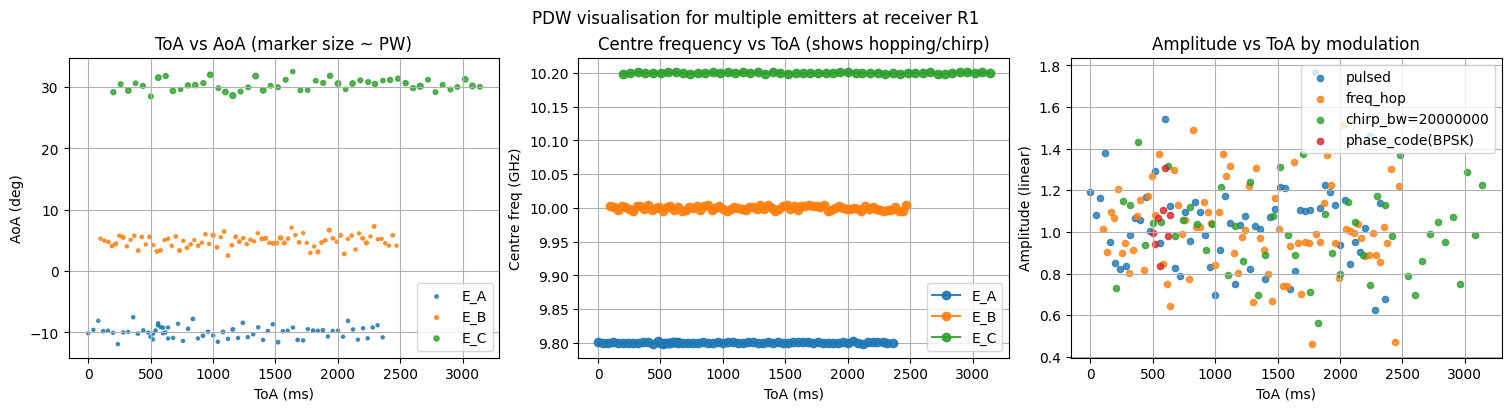


Sample PDW table (first 10 rows):
  emitter_id receiver_id       ToA        AoA        PW           f_c  \
0        E_A          R1 -0.000502 -10.161286  0.000070  9.801163e+09   
1        E_A          R1  0.041803  -9.595949  0.000086  9.800010e+09   
2        E_A          R1  0.080928  -8.113814  0.000091  9.799018e+09   
3        E_B          R1  0.098636   5.270457  0.000092  1.000357e+10   
4        E_A          R1  0.120395  -9.825422  0.000121  9.800462e+09   
5        E_B          R1  0.129343   4.949762  0.000071  1.000071e+10   
6        E_A          R1  0.158624  -9.742450  0.000107  9.800199e+09   
7        E_B          R1  0.161351   4.761052  0.000114  9.996429e+09   
8        E_B          R1  0.191171   4.092436  0.000137  1.000214e+10   
9        E_A          R1  0.198624 -10.074446  0.000065  9.799400e+09   

   Amplitude     Phase Modulation  
0   1.192675 -2.949954     pulsed  
1   1.082556 -2.906927     pulsed  
2   1.164412  2.026959     pulsed  
3   1.014313 -0.6

In [5]:
if __name__ == '__main__':
    df_all = example_run_and_plot()


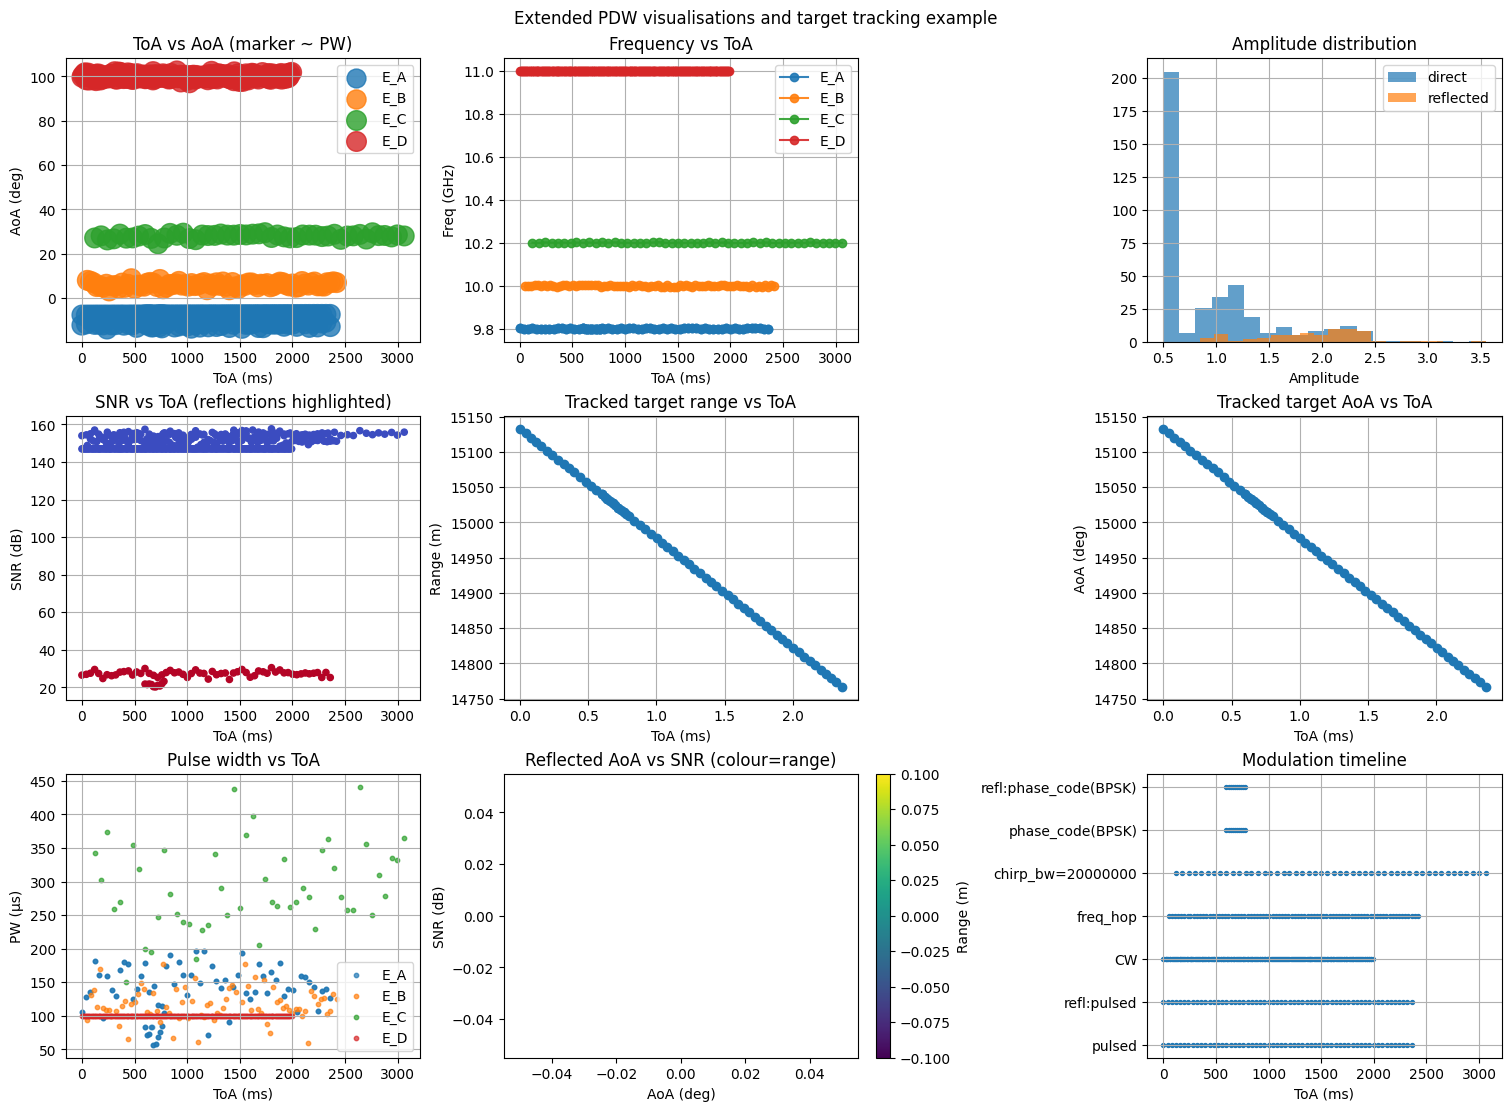


Sample PDW rows (first 12):
emitter_id    Source       ToA    ToA_ms        AoA      Range_m       PW          f_c  Amplitude     SNR_dB
       E_A    direct -0.000502 -0.501840 -12.161286          NaN 0.000106 9.801163e+09   2.385350 153.989171
       E_A reflected -0.000401 -0.400884  -7.594700 15132.823882 0.000106 9.801163e+09   2.385350  26.537238
       E_D    direct -0.000077 -0.077221  99.645892          NaN 0.000100 1.100000e+10   0.500000 146.964887
       E_D    direct  0.007472  7.472311 100.453538          NaN 0.000100 1.100000e+10   0.500000 146.964887
       E_D    direct  0.023707 23.707499 101.224584          NaN 0.000100 1.100000e+10   0.500000 146.964887
       E_D    direct  0.029453 29.453053 101.623397          NaN 0.000100 1.100000e+10   0.500000 146.964887
       E_D    direct  0.040148 40.148174  98.463052          NaN 0.000100 1.100000e+10   0.500000 146.964887
       E_A    direct  0.041803 41.802857 -11.595949          NaN 0.000128 9.800010e+09   2.165112 1

KeyError: "['ToA_ms'] not in index"

In [6]:
"""
radar_pdw_extended.py

Extensions to RadarPDWGenerator:
 - extra example emitters and modes
 - more PDW visualisations
 - simple SNR modelling (thermal noise + NF + simplified radar equation)
 - target reflection simulator that produces reflected PDWs for a moving target
 - example showing a target tracked by ToA->range and AoA over time

Units: seconds, Hz, metres, degrees, Watts, dB where noted.
"""
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# reproducible
np.random.seed(42)

# physical constants
c = 299792458.0           # speed of light m/s
k_B = 1.380649e-23        # Boltzmann constant J/K

@dataclass
class PulseDescriptor:
    emitter_id: str
    receiver_id: str
    ToA: float
    AoA: float
    PW: float
    f_c: float
    Amplitude: float
    Phase: float
    Modulation: str
    SNR_dB: float = np.nan
    Range_m: float = np.nan
    Source: str = 'direct'  # 'direct' or 'reflected'

class RadarPDWGenerator:
    def __init__(self, receiver_id='R1', receiver_pos=(0.0, 0.0), noise_temp=290.0, noise_figure_dB=5.0):
        self.receiver_id = receiver_id
        self.receiver_pos = np.array(receiver_pos, dtype=float)
        self.noise_temp = noise_temp
        self.noise_figure_dB = noise_figure_dB

    def _jittered_times(self, start, n, pri, jitter_frac=0.05):
        base = start + np.arange(n) * pri
        jitter = (np.random.uniform(-1, 1, size=n) * pri * jitter_frac)
        return base + jitter

    def generate_pulse_train(self,
                             emitter_id: str,
                             mode: str = 'pulsed',
                             n_pulses: int = 50,
                             start_time: float = 0.0,
                             pri: float = 0.05,
                             pw_mean: float = 1e-4,
                             pw_jitter_frac: float = 0.2,
                             fc_mean: float = 10e9,
                             fc_jitter: float = 1e6,
                             aoa_mean: float = 0.0,
                             aoa_jitter: float = 1.0,
                             amp_mean: float = 1.0,
                             amp_jitter_frac: float = 0.2,
                             phase_jitter: float = np.pi):
        # Times and widths
        if mode == 'CW':
            times = self._jittered_times(start_time, n_pulses, pri, jitter_frac=0.5)
            pws = np.full(n_pulses, pw_mean * 0.1)
            modulation = 'CW'
        else:
            times = self._jittered_times(start_time, n_pulses, pri)
            pws = pw_mean * (1 + pw_jitter_frac * np.random.randn(n_pulses))
            pws = np.clip(pws, pw_mean * 0.05, pw_mean * 5)
        # other PDWs
        aoas = aoa_mean + aoa_jitter * np.random.randn(n_pulses)
        amps = amp_mean * np.abs(1 + amp_jitter_frac * np.random.randn(n_pulses))
        phases = np.random.uniform(-phase_jitter, phase_jitter, size=n_pulses)
        # frequency behaviour
        if mode == 'pulsed':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = 'pulsed'
        elif mode == 'freq_hop':
            channels = fc_mean + np.linspace(-5*fc_jitter, 5*fc_jitter, 8)
            fcs = np.random.choice(channels, size=n_pulses)
            modulation = 'freq_hop'
        elif mode == 'chirp':
            chirp_bw = 20e6
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = f'chirp_bw={int(chirp_bw)}'
        elif mode == 'phase_code':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            phases = np.random.choice([0.0, np.pi], size=n_pulses)
            modulation = 'phase_code(BPSK)'
        elif mode == 'CW':
            fcs = np.full(n_pulses, fc_mean)
            amps = np.full(n_pulses, amp_mean)
            modulation = 'CW'
        else:
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = str(mode)
        # assemble
        records = []
        for i in range(n_pulses):
            pdw = PulseDescriptor(
                emitter_id=emitter_id,
                receiver_id=self.receiver_id,
                ToA=float(times[i]),
                AoA=float(aoas[i]),
                PW=float(pws[i]),
                f_c=float(fcs[i]),
                Amplitude=float(amps[i]),
                Phase=float(phases[i]),
                Modulation=modulation,
                Source='direct'
            )
            records.append(pdw.__dict__)
        return pd.DataFrame.from_records(records)

    def combine_emitters(self, df_list):
        return pd.concat(df_list, ignore_index=True).sort_values('ToA').reset_index(drop=True)

    # ---------- SNR modelling ----------
    def compute_noise_power(self, pw_s):
        # approximate noise bandwidth = 1 / PW for short pulses
        B = 1.0 / np.maximum(pw_s, 1e-9)
        NF_linear = 10 ** (self.noise_figure_dB / 10.0)
        noise_power = k_B * self.noise_temp * B * NF_linear
        return noise_power  # Watts

    def pdw_to_received_power(self, tx_power_W, tx_gain_linear, rx_gain_linear, sigma_m2, range_m, fc_Hz, bistatic=False):
        # simplified monostatic radar equation for returned power:
        # Pr = Pt * Gt * Gr * lambda^2 * sigma / ((4*pi)^3 * R^4)  (monostatic, R = range to target)
        # For bistatic geometry this changes; keep monostatic for reflected-signal modelling.
        lam = c / fc_Hz
        Pr = tx_power_W * tx_gain_linear * rx_gain_linear * (lam ** 2) * sigma_m2 / ((4 * np.pi) ** 3 * (range_m ** 4))
        return Pr

    def add_snr_column(self, df, tx_power_W=10.0, tx_gain_dBi=30.0, rx_gain_dBi=30.0, sigma_m2=1.0):
        # tx_power_W: nominal transmitted power associated with amplitude=1.0
        Gt = 10 ** (tx_gain_dBi / 10.0)
        Gr = 10 ** (rx_gain_dBi / 10.0)
        # compute noise power per pulse
        noise_power_vec = self.compute_noise_power(df['PW'].values)
        # map amplitude to transmit power scaling
        Pt_vec = tx_power_W * df['Amplitude'].values
        # If Range_m present and Source=='reflected' then use radar eqn; otherwise use simple free-space direct power model
        Pr_list = []
        for i, row in df.iterrows():
            if row.get('Source', 'direct') == 'reflected' and not np.isnan(row.get('Range_m', np.nan)):
                R = max(row['Range_m'], 1.0)
                Pr = self.pdw_to_received_power(Pt_vec[i], Gt, Gr, sigma_m2, R, row['f_c'])
            else:
                # direct received power proportional to Pt / (4*pi*R^2) if Range known; otherwise use Pt scaled by 1 (placeholder)
                R = row.get('Range_m', np.nan)
                if not np.isnan(R):
                    Pr = Pt_vec[i] * Gt * Gr * ( (c/row['f_c'])**2 ) / ((4*np.pi*R)**2)
                else:
                    Pr = Pt_vec[i] * 1e-3  # fallback very small
            Pr_list.append(Pr)
        Pr_arr = np.array(Pr_list)
        SNR_linear = Pr_arr / noise_power_vec
        # convert to dB
        df = df.copy()
        df['Pr_W'] = Pr_arr
        df['Noise_W'] = noise_power_vec
        df['SNR_linear'] = SNR_linear
        df['SNR_dB'] = 10 * np.log10(np.maximum(SNR_linear, 1e-30))
        return df

    # ---------- Target reflection simulator ----------
    def simulate_target_reflections(self, tx_df, target_init_pos, target_velocity, rcs_m2=1.0):
        """
        tx_df: DataFrame of transmitted PDWs (direct pulses) from one emitter.
        target_init_pos: (x,y) metres in receiver-centric coordinates at t=0
        target_velocity: (vx,vy) m/s (constant)
        Returns: DataFrame of reflected PDWs with ToA = tx_time + 2*range/c, AoA = bearing, Range_m, Source='reflected'
        """
        tx = tx_df.sort_values('ToA').reset_index(drop=True)
        reflected = []
        for i, row in tx.iterrows():
            t_tx = row['ToA']
            # target position at transmit time
            pos = np.array(target_init_pos) + np.array(target_velocity) * t_tx
            range_m = np.linalg.norm(pos - self.receiver_pos)
            # two-way travel time
            t_rx = t_tx + 2.0 * range_m / c
            # AoA is bearing from receiver to target in degrees
            bearing_rad = np.arctan2(pos[1] - self.receiver_pos[1], pos[0] - self.receiver_pos[0])
            aoa_deg = np.degrees(bearing_rad)
            # reflected amplitude: keep original amplitude (scaling occurs in radar eqn) but mark source
            pdw = PulseDescriptor(
                emitter_id=row['emitter_id'],
                receiver_id=self.receiver_id,
                ToA=float(t_rx),
                AoA=float(aoa_deg),
                PW=float(row['PW']),
                f_c=float(row['f_c']),
                Amplitude=float(row['Amplitude']),
                Phase=float(row['Phase']),
                Modulation=f"refl:{row['Modulation']}",
                Range_m=float(range_m),
                Source='reflected'
            )
            reflected.append(pdw.__dict__)
        return pd.DataFrame.from_records(reflected)

# -----------------------
# Extended examples + plots
# -----------------------
def extended_example():
    gen = RadarPDWGenerator(receiver_id='R1', receiver_pos=(0.0, 0.0), noise_temp=290.0, noise_figure_dB=4.0)

    # Emitters: diverse modes and parameters
    emitters = [
        dict(emitter_id='E_A', mode='pulsed', n_pulses=60, start_time=0.0, pri=0.04,
             pw_mean=150e-6, fc_mean=9.8e9, aoa_mean=-12.0, amp_mean=2.0),
        dict(emitter_id='E_B', mode='freq_hop', n_pulses=80, start_time=0.05, pri=0.03,
             pw_mean=120e-6, fc_mean=10.0e9, aoa_mean=6.0, amp_mean=1.2),
        dict(emitter_id='E_C', mode='chirp', n_pulses=50, start_time=0.12, pri=0.06,
             pw_mean=300e-6, fc_mean=10.2e9, aoa_mean=28.0, amp_mean=1.0),
        dict(emitter_id='E_D', mode='CW', n_pulses=200, start_time=0.0, pri=0.01,
             pw_mean=1e-3, fc_mean=11.0e9, aoa_mean=100.0, amp_mean=0.5)
    ]

    df_list = []
    for e in emitters:
        df_tx = gen.generate_pulse_train(**e)
        # Inject a short phase-coded burst for E_A
        if e['emitter_id'] == 'E_A':
            burst = gen.generate_pulse_train(e['emitter_id'], mode='phase_code', n_pulses=10,
                                             start_time=e['start_time'] + 0.6, pri=0.02,
                                             pw_mean=80e-6, fc_mean=e['fc_mean'], aoa_mean=e['aoa_mean'])
            df_tx = pd.concat([df_tx, burst], ignore_index=True)
        df_list.append(df_tx)

    tx_combined = gen.combine_emitters(df_list)

    # ---------- Target tracking example ----------
    # Define a moving target crossing near receiver. Start at x=15000 m, y=-2000 m, moving towards +x at -50 m/s in y and -150 m/s in x.
    target_init = (15000.0, -2000.0)
    target_velocity = (-150.0, 50.0)  # m/s (vx, vy)
    # Choose one emitter (E_A) illuminating the target; simulate reflections for E_A transmissions.
    tx_EA = tx_combined[tx_combined['emitter_id'] == 'E_A'].reset_index(drop=True)
    refl = gen.simulate_target_reflections(tx_EA, target_init, target_velocity, rcs_m2=2.0)

    # Combine direct Tx PDWs and reflected PDWs
    all_pdws = pd.concat([tx_combined, refl], ignore_index=True).sort_values('ToA').reset_index(drop=True)

    # Add SNR estimates assuming Pt mapping: Amplitude=1 -> 100 W transmit (example), gains 35 dBi, sigma used per reflection
    all_pdws = gen.add_snr_column(all_pdws, tx_power_W=100.0, tx_gain_dBi=35.0, rx_gain_dBi=35.0, sigma_m2=2.0)

    # Convert units for plotting
    all_pdws['ToA_ms'] = all_pdws['ToA'] * 1e3
    all_pdws['PW_us'] = all_pdws['PW'] * 1e6
    all_pdws['f_GHz'] = all_pdws['f_c'] / 1e9

    # ---------- Plots ----------
    fig, axes = plt.subplots(3, 3, figsize=(15, 11), constrained_layout=True)

    # Plot A: ToA vs AoA marker size ~ PW, colour by emitter
    ax = axes[0, 0]
    for eid, group in all_pdws.groupby('emitter_id'):
        ax.scatter(group['ToA_ms'], group['AoA'], s=np.clip(group['PW_us']*3, 5, 200),
                   label=eid, alpha=0.8)
    ax.set_xlabel('ToA (ms)')
    ax.set_ylabel('AoA (deg)')
    ax.set_title('ToA vs AoA (marker ~ PW)')
    ax.legend(); ax.grid(True)

    # Plot B: Centre frequency vs ToA per emitter (shows hopping/chirp)
    ax = axes[0, 1]
    for eid, group in all_pdws.groupby('emitter_id'):
        g = group.sort_values('ToA')
        ax.plot(g['ToA_ms'], g['f_GHz'], marker='o', linestyle='-', label=eid, alpha=0.9)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Freq (GHz)'); ax.set_title('Frequency vs ToA'); ax.grid(True); ax.legend()

    # Plot C: Amplitude histogram by source type
    ax = axes[0, 2]
    direct = all_pdws[all_pdws['Source'] == 'direct']
    refl_pd = all_pdws[all_pdws['Source'] == 'reflected']
    ax.hist(direct['Amplitude'], bins=20, alpha=0.7, label='direct')
    ax.hist(refl_pd['Amplitude'], bins=20, alpha=0.7, label='reflected')
    ax.set_xlabel('Amplitude'); ax.set_title('Amplitude distribution'); ax.legend(); ax.grid(True)

    # Plot D: SNR vs ToA, highlight reflected pulses (tracking)
    ax = axes[1, 0]
    ax.scatter(all_pdws['ToA_ms'], all_pdws['SNR_dB'], c=(all_pdws['Source']=='reflected'), cmap='coolwarm', s=20)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('SNR (dB)'); ax.set_title('SNR vs ToA (reflections highlighted)'); ax.grid(True)

    # Plot E: Range estimates for reflected pulses vs ToA (tracking)
    ax = axes[1, 1]
    refl_sorted = refl.sort_values('ToA')
    # estimate range from ToA for reflected pulses: R = c*(t_rx - t_tx)/2 not directly available unless we store tx time.
    # we have Range_m stored from simulation.
    ax.plot(refl_sorted['ToA'], refl_sorted['Range_m'], marker='o', linestyle='-', label='tracked target')

    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Range (m)'); ax.set_title('Tracked target range vs ToA'); ax.grid(True)

    # Plot F: AoA of reflected pulses vs ToA (shows bearing change during track)
    ax = axes[1, 2]
    ax.plot(refl_sorted['ToA'], refl_sorted['Range_m'], marker='o', linestyle='-', label='tracked target')

    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('AoA (deg)'); ax.set_title('Tracked target AoA vs ToA'); ax.grid(True)

    # Plot G: PW vs ToA for each emitter (show pulse width modes)
    ax = axes[2, 0]
    for eid, group in all_pdws.groupby('emitter_id'):
        ax.scatter(group['ToA_ms'], group['PW_us'], s=10, label=eid, alpha=0.7)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('PW (µs)'); ax.set_title('Pulse width vs ToA'); ax.legend(); ax.grid(True)

    # Plot H: Polar-like scatter: AoA vs SNR for reflected pulses (quick check)
    ax = axes[2, 1]
    sc = ax.scatter(refl['AoA'], refl['SNR_dB'], c=refl['Range_m'], cmap='viridis', s=40)
    ax.set_xlabel('AoA (deg)'); ax.set_ylabel('SNR (dB)'); ax.set_title('Reflected AoA vs SNR (colour=range)')
    plt.colorbar(sc, ax=ax, label='Range (m)')

    # Plot I: Example timeline of modulation types (stacked markers)
    ax = axes[2, 2]
    mods = all_pdws['Modulation'].unique()
    mod_map = {m: i for i, m in enumerate(mods)}
    ax.scatter(all_pdws['ToA_ms'], [mod_map[m] for m in all_pdws['Modulation']], s=8)
    ax.set_yticks(list(mod_map.values())); ax.set_yticklabels(list(mod_map.keys()))
    ax.set_xlabel('ToA (ms)'); ax.set_title('Modulation timeline'); ax.grid(True)

    plt.suptitle('Extended PDW visualisations and target tracking example')
    plt.show()

    # Print key table: first 12 rows and tracked reflections summary
    print("\nSample PDW rows (first 12):")
    print(all_pdws[['emitter_id','Source','ToA','ToA_ms','AoA','Range_m','PW','f_c','Amplitude','SNR_dB']].head(12).to_string(index=False))

    print("\nTracked reflections summary (first 12):")
    print(refl[['ToA','ToA_ms','AoA','Range_m','PW','f_c','Amplitude','SNR_dB']].head(12).to_string(index=False))

    return all_pdws, refl

if __name__ == '__main__':
    all_pdws, refl = extended_example()


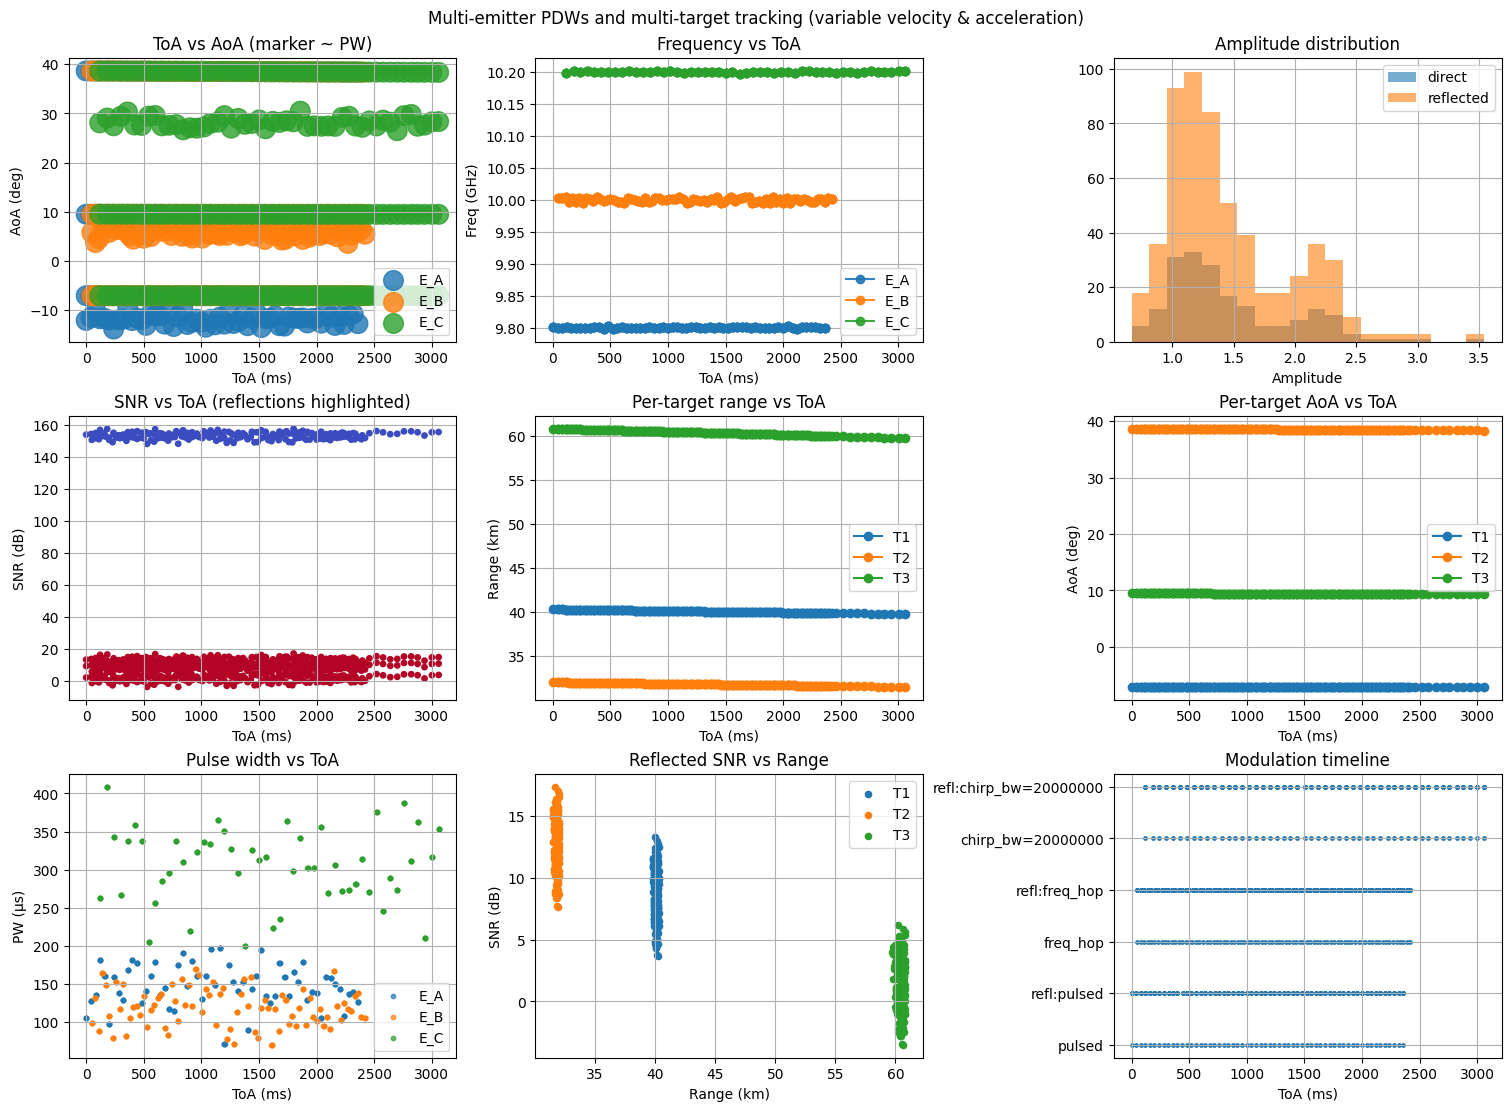


--- Sample combined PDWs (first 12 rows) ---
emitter_id    Source       ToA    ToA_ms        AoA      Range_m       PW          f_c  Amplitude     SNR_dB
       E_A    direct -0.000502 -0.501840 -12.161286          NaN 0.000106 9.801163e+09   2.385350 153.989171
       E_A reflected -0.000288 -0.288254  38.659857 32015.707399 0.000106 9.801163e+09   2.385350  13.519513
       E_A reflected -0.000233 -0.232911  -7.125020 40311.390204 0.000106 9.801163e+09   2.385350   9.516926
       E_A reflected -0.000096 -0.096040   9.462336 60827.780403 0.000106 9.801163e+09   2.385350   2.369958
       E_A    direct  0.041803 41.802857 -11.595949          NaN 0.000128 9.800010e+09   2.165112 154.415800
       E_A reflected  0.042016 42.016395  38.655718 32008.439908 0.000128 9.800010e+09   2.165112  13.951107
       E_A reflected  0.042072 42.071729  -7.124725 40302.855063 0.000128 9.800010e+09   2.165112   9.948255
       E_A reflected  0.042209 42.208569   9.461169 60814.680883 0.000128 9.800010

KeyError: "['SNR_dB'] not in index"

In [7]:
"""
radar_pdw_multi_target_tracking.py

- Generates transmit PDWs for multiple emitters.
- Simulates reflections from multiple moving targets with variable velocity and acceleration.
- Computes updated Range, ToA (round-trip), AoA, and SNR for reflected PDWs.
- Produces plots per-target and combined PDW visualisations.

Units: seconds, Hz, metres, degrees, Watts, dB.
"""

from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducible RNG
np.random.seed(42)

# Physical constants
c = 299792458.0           # speed of light (m/s)
k_B = 1.380649e-23        # Boltzmann constant J/K

@dataclass
class PulseDescriptor:
    emitter_id: str
    receiver_id: str
    ToA: float
    AoA: float
    PW: float
    f_c: float
    Amplitude: float
    Phase: float
    Modulation: str
    SNR_dB: float = np.nan
    Range_m: float = np.nan
    Source: str = 'direct'  # 'direct' or 'reflected'

class RadarPDWGenerator:
    def __init__(self, receiver_id='R1', receiver_pos=(0.0, 0.0), noise_temp=290.0, noise_figure_dB=4.0):
        self.receiver_id = receiver_id
        self.receiver_pos = np.array(receiver_pos, dtype=float)
        self.noise_temp = noise_temp
        self.noise_figure_dB = noise_figure_dB

    def _jittered_times(self, start, n, pri, jitter_frac=0.05):
        base = start + np.arange(n) * pri
        jitter = (np.random.uniform(-1, 1, size=n) * pri * jitter_frac)
        return base + jitter

    def generate_pulse_train(self,
                             emitter_id: str,
                             mode: str = 'pulsed',
                             n_pulses: int = 50,
                             start_time: float = 0.0,
                             pri: float = 0.05,
                             pw_mean: float = 1e-4,
                             pw_jitter_frac: float = 0.2,
                             fc_mean: float = 10e9,
                             fc_jitter: float = 1e6,
                             aoa_mean: float = 0.0,
                             aoa_jitter: float = 1.0,
                             amp_mean: float = 1.0,
                             amp_jitter_frac: float = 0.2,
                             phase_jitter: float = np.pi):
        if mode == 'CW':
            times = self._jittered_times(start_time, n_pulses, pri, jitter_frac=0.5)
            pws = np.full(n_pulses, pw_mean * 0.1)
            modulation = 'CW'
        else:
            times = self._jittered_times(start_time, n_pulses, pri)
            pws = pw_mean * (1 + pw_jitter_frac * np.random.randn(n_pulses))
            pws = np.clip(pws, pw_mean * 0.05, pw_mean * 5)
        aoas = aoa_mean + aoa_jitter * np.random.randn(n_pulses)
        amps = amp_mean * np.abs(1 + amp_jitter_frac * np.random.randn(n_pulses))
        phases = np.random.uniform(-phase_jitter, phase_jitter, size=n_pulses)

        if mode == 'pulsed':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = 'pulsed'
        elif mode == 'freq_hop':
            channels = fc_mean + np.linspace(-5*fc_jitter, 5*fc_jitter, 8)
            fcs = np.random.choice(channels, size=n_pulses)
            modulation = 'freq_hop'
        elif mode == 'chirp':
            chirp_bw = 20e6
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = f'chirp_bw={int(chirp_bw)}'
        elif mode == 'phase_code':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            phases = np.random.choice([0.0, np.pi], size=n_pulses)
            modulation = 'phase_code(BPSK)'
        elif mode == 'CW':
            fcs = np.full(n_pulses, fc_mean)
            amps = np.full(n_pulses, amp_mean)
            modulation = 'CW'
        else:
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = str(mode)

        records = []
        for i in range(n_pulses):
            pdw = PulseDescriptor(
                emitter_id=emitter_id,
                receiver_id=self.receiver_id,
                ToA=float(times[i]),
                AoA=float(aoas[i]),
                PW=float(pws[i]),
                f_c=float(fcs[i]),
                Amplitude=float(amps[i]),
                Phase=float(phases[i]),
                Modulation=modulation,
                Source='direct'
            )
            records.append(pdw.__dict__)
        return pd.DataFrame.from_records(records)

    def combine_emitters(self, df_list):
        return pd.concat(df_list, ignore_index=True).sort_values('ToA').reset_index(drop=True)

    # ---------- SNR helpers ----------
    def compute_noise_power(self, pw_s):
        B = 1.0 / np.maximum(pw_s, 1e-9)
        NF_linear = 10 ** (self.noise_figure_dB / 10.0)
        noise_power = k_B * self.noise_temp * B * NF_linear
        return noise_power

    def pdw_to_received_power(self, tx_power_W, tx_gain_linear, rx_gain_linear, sigma_m2, range_m, fc_Hz):
        lam = c / fc_Hz
        Pr = tx_power_W * tx_gain_linear * rx_gain_linear * (lam ** 2) * sigma_m2 / ((4 * np.pi) ** 3 * (range_m ** 4))
        return Pr

    def add_snr_column(self, df, tx_power_W=10.0, tx_gain_dBi=30.0, rx_gain_dBi=30.0, sigma_m2=1.0):
        Gt = 10 ** (tx_gain_dBi / 10.0)
        Gr = 10 ** (rx_gain_dBi / 10.0)
        noise_power_vec = self.compute_noise_power(df['PW'].values)
        Pt_vec = tx_power_W * df['Amplitude'].values
        Pr_list = []
        for i, row in df.iterrows():
            if row.get('Source', 'direct') == 'reflected' and not np.isnan(row.get('Range_m', np.nan)):
                R = max(row['Range_m'], 1.0)
                Pr = self.pdw_to_received_power(Pt_vec[i], Gt, Gr, sigma_m2, R, row['f_c'])
            else:
                R = row.get('Range_m', np.nan)
                if not np.isnan(R):
                    Pr = Pt_vec[i] * Gt * Gr * ((c/row['f_c'])**2) / ((4*np.pi*R)**2)
                else:
                    Pr = Pt_vec[i] * 1e-3
            Pr_list.append(Pr)
        Pr_arr = np.array(Pr_list)
        SNR_linear = Pr_arr / noise_power_vec
        df = df.copy()
        df['Pr_W'] = Pr_arr
        df['Noise_W'] = noise_power_vec
        df['SNR_linear'] = SNR_linear
        df['SNR_dB'] = 10 * np.log10(np.maximum(SNR_linear, 1e-30))
        return df

    # ---------- Target reflection for moving target with acceleration ----------
    def simulate_target_reflections_from_tx(self, tx_df, targets):
        """
        tx_df: DataFrame of transmitted PDWs (from one or many emitters).
        targets: list of dicts, each dict has:
           - id: str
           - p0: (x,y) initial position at t=0 (m)
           - v0: (vx,vy) initial velocity (m/s)
           - a:  (ax,ay) constant acceleration (m/s^2)
           - rcs: radar cross section (m^2)
        Returns DataFrame of reflected PDWs for all targets.
        """
        tx = tx_df.sort_values('ToA').reset_index(drop=True)
        reflected_records = []
        for targ in targets:
            tid = targ['id']
            p0 = np.array(targ['p0'], dtype=float)
            v0 = np.array(targ.get('v0', (0.0, 0.0)), dtype=float)
            a = np.array(targ.get('a', (0.0, 0.0)), dtype=float)
            rcs = float(targ.get('rcs', 1.0))
            for i, row in tx.iterrows():
                t_tx = row['ToA']
                # kinematic update: p(t) = p0 + v0*t + 0.5*a*t^2
                pos = p0 + v0 * t_tx + 0.5 * a * (t_tx**2)
                range_m = np.linalg.norm(pos - self.receiver_pos)
                # two-way delay: tx_time + 2*range/c
                t_rx = t_tx + 2.0 * range_m / c
                # AoA bearing from receiver to target in degrees
                bearing_rad = np.arctan2(pos[1] - self.receiver_pos[1], pos[0] - self.receiver_pos[0])
                aoa_deg = np.degrees(bearing_rad)
                pdw = PulseDescriptor(
                    emitter_id=row['emitter_id'],
                    receiver_id=self.receiver_id,
                    ToA=float(t_rx),
                    AoA=float(aoa_deg),
                    PW=float(row['PW']),
                    f_c=float(row['f_c']),
                    Amplitude=float(row['Amplitude']),
                    Phase=float(row['Phase']),
                    Modulation=f"refl:{row['Modulation']}",
                    Range_m=float(range_m),
                    Source='reflected'
                )
                # attach target id as extra field
                rec = pdw.__dict__.copy()
                rec['target_id'] = tid
                reflected_records.append(rec)
        if len(reflected_records) == 0:
            return pd.DataFrame(columns=['emitter_id','receiver_id','ToA','AoA','PW','f_c','Amplitude','Phase','Modulation','SNR_dB','Range_m','Source','target_id'])
        return pd.DataFrame.from_records(reflected_records)

# -----------------------
# Full example: multi-emitter, multi-target
# -----------------------
def full_run_and_plot():
    gen = RadarPDWGenerator(receiver_id='R1', receiver_pos=(0.0, 0.0), noise_temp=290.0, noise_figure_dB=4.0)

    # Define transmitters
    emitters = [
        dict(emitter_id='E_A', mode='pulsed', n_pulses=60, start_time=0.0, pri=0.04, pw_mean=150e-6, fc_mean=9.8e9, aoa_mean=-12.0, amp_mean=2.0),
        dict(emitter_id='E_B', mode='freq_hop', n_pulses=80, start_time=0.05, pri=0.03, pw_mean=120e-6, fc_mean=10.0e9, aoa_mean=6.0, amp_mean=1.2),
        dict(emitter_id='E_C', mode='chirp', n_pulses=50, start_time=0.12, pri=0.06, pw_mean=300e-6, fc_mean=10.2e9, aoa_mean=28.0, amp_mean=1.0)
    ]

    tx_dfs = []
    for e in emitters:
        tx = gen.generate_pulse_train(**e)
        tx_dfs.append(tx)
    tx_all = gen.combine_emitters(tx_dfs)

    # Define multiple moving targets with variable velocity and acceleration
    # Example: target1 closes then recedes due to acceleration sign change; target2 passes by with constant speed; target3 accelerates towards receiver.
    targets = [
        {'id': 'T1', 'p0': (40000.0, -5000.0), 'v0': (-200.0, 30.0), 'a': (20.0, -5.0), 'rcs': 2.0},
        {'id': 'T2', 'p0': (25000.0, 20000.0), 'v0': (-100.0, -150.0), 'a': (0.0, 0.0), 'rcs': 1.0},
        {'id': 'T3', 'p0': (60000.0, 10000.0), 'v0': (-300.0, -80.0), 'a': (-30.0, 10.0), 'rcs': 5.0}
    ]

    # Simulate reflections from all transmit PDWs for all targets
    refl_all = gen.simulate_target_reflections_from_tx(tx_all, targets)

    # Combine original tx PDWs with reflections
    combined = pd.concat([tx_all, refl_all.drop(columns=['target_id'])], ignore_index=True).sort_values('ToA').reset_index(drop=True)

    # Compute SNR. Use mapping: Amplitude=1 -> tx_power_W=100 W. Use tx/rcs params.
    # For reflected pulses we want radar-equation; gen.add_snr_column handles that when Range_m present in dataframe.
    # Ensure Range_m NaN for direct pulses, filled for reflected ones.
    combined['Range_m'] = combined.get('Range_m', np.nan)
    combined = gen.add_snr_column(combined, tx_power_W=100.0, tx_gain_dBi=35.0, rx_gain_dBi=35.0, sigma_m2=2.0)

    # Attach target_id back into reflected DF for plotting convenience
    if not refl_all.empty:
        refl_all_snr = refl_all.merge(combined[['ToA','SNR_dB','Pr_W','Noise_W']], on='ToA', how='left', suffixes=('','_x'))
        # Some ToA duplicates may exist; merge on index would be more robust. For plotting we will use refl_all_snr as-is.
    else:
        refl_all_snr = pd.DataFrame()

    # Unit conversions for plotting
    combined['ToA_ms'] = combined['ToA'] * 1e3
    combined['PW_us'] = combined['PW'] * 1e6
    combined['f_GHz'] = combined['f_c'] / 1e9

    if not refl_all.empty:
        refl_all['ToA_ms'] = refl_all['ToA'] * 1e3
        refl_all['Range_km'] = refl_all['Range_m'] / 1e3

    # -----------------------
    # Plots
    # -----------------------
    plt.style.use('default')
    fig, axs = plt.subplots(3, 3, figsize=(15, 11), constrained_layout=True)

    # 1) ToA vs AoA, marker size ~ PW, colour by emitter
    ax = axs[0,0]
    for eid, grp in combined.groupby('emitter_id'):
        ax.scatter(grp['ToA_ms'], grp['AoA'], s=np.clip(grp['PW_us']*3, 6, 200), label=eid, alpha=0.8)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('AoA (deg)'); ax.set_title('ToA vs AoA (marker ~ PW)'); ax.grid(True); ax.legend()

    # 2) Centre frequency vs ToA per emitter
    ax = axs[0,1]
    for eid, grp in combined.groupby('emitter_id'):
        g = grp.sort_values('ToA')
        ax.plot(g['ToA_ms'], g['f_GHz'], marker='o', linestyle='-', label=eid, alpha=0.9)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Freq (GHz)'); ax.set_title('Frequency vs ToA'); ax.grid(True); ax.legend()

    # 3) Amplitude histogram split by direct/reflected
    ax = axs[0,2]
    direct = combined[combined['Source']=='direct']
    reflected = combined[combined['Source']=='reflected']
    ax.hist(direct['Amplitude'], bins=20, alpha=0.6, label='direct')
    ax.hist(reflected['Amplitude'], bins=20, alpha=0.6, label='reflected')
    ax.set_xlabel('Amplitude'); ax.set_title('Amplitude distribution'); ax.legend(); ax.grid(True)

    # 4) SNR timeline with reflections highlighted
    ax = axs[1,0]
    ax.scatter(combined['ToA_ms'], combined['SNR_dB'], c=(combined['Source']=='reflected'), cmap='coolwarm', s=15)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('SNR (dB)'); ax.set_title('SNR vs ToA (reflections highlighted)'); ax.grid(True)

    # 5) Per-target Range vs ToA (approach/recede visible from kinematics)
    ax = axs[1,1]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid].sort_values('ToA')
        if not refl_tid.empty:
            ax.plot(refl_tid['ToA_ms'], refl_tid['Range_m']/1e3, marker='o', linestyle='-', label=tid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Range (km)'); ax.set_title('Per-target range vs ToA'); ax.grid(True); ax.legend()

    # 6) Per-target AoA vs ToA
    ax = axs[1,2]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid].sort_values('ToA')
        if not refl_tid.empty:
            ax.plot(refl_tid['ToA_ms'], refl_tid['AoA'], marker='o', linestyle='-', label=tid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('AoA (deg)'); ax.set_title('Per-target AoA vs ToA'); ax.grid(True); ax.legend()

    # 7) PW vs ToA per emitter
    ax = axs[2,0]
    for eid, grp in combined.groupby('emitter_id'):
        ax.scatter(grp['ToA_ms'], grp['PW_us'], s=10, alpha=0.7, label=eid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('PW (µs)'); ax.set_title('Pulse width vs ToA'); ax.grid(True); ax.legend()

    # 8) Reflected SNR vs Range (per target)
    ax = axs[2,1]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid].sort_values('Range_m')
        if not refl_tid.empty:
            # find SNRs by matching ToA in combined (robustness: merge by ToA and emitter_id)
            merged = pd.merge(refl_tid[['ToA','Range_m','target_id']], combined[['ToA','SNR_dB']], on='ToA', how='left')
            ax.scatter(merged['Range_m']/1e3, merged['SNR_dB'], label=tid, s=20)
    ax.set_xlabel('Range (km)'); ax.set_ylabel('SNR (dB)'); ax.set_title('Reflected SNR vs Range'); ax.grid(True); ax.legend()

    # 9) Timeline of modulation types (stacked)
    ax = axs[2,2]
    mods = combined['Modulation'].unique()
    mod_map = {m: i for i, m in enumerate(mods)}
    ax.scatter(combined['ToA_ms'], [mod_map[m] for m in combined['Modulation']], s=6)
    ax.set_yticks(list(mod_map.values())); ax.set_yticklabels(list(mod_map.keys()))
    ax.set_xlabel('ToA (ms)'); ax.set_title('Modulation timeline'); ax.grid(True)

    plt.suptitle('Multi-emitter PDWs and multi-target tracking (variable velocity & acceleration)')
    plt.show()

    # Print short tables
    print("\n--- Sample combined PDWs (first 12 rows) ---")
    print(combined[['emitter_id','Source','ToA','ToA_ms','AoA','Range_m','PW','f_c','Amplitude','SNR_dB']].head(12).to_string(index=False))

    if not refl_all.empty:
        print("\n--- Sample reflected PDWs (first 12 rows) with target ids ---")
        # attach SNR via merge for display
        refl_disp = refl_all.merge(combined[['ToA','SNR_dB']], on='ToA', how='left')
        print(refl_disp[['target_id','emitter_id','ToA','ToA_ms','AoA','Range_m','PW','f_c','Amplitude','SNR_dB']].head(12).to_string(index=False))

    return combined, refl_all

if __name__ == '__main__':
    combined_df, reflections_df = full_run_and_plot()


KeyError: 'Doppler_Hz'

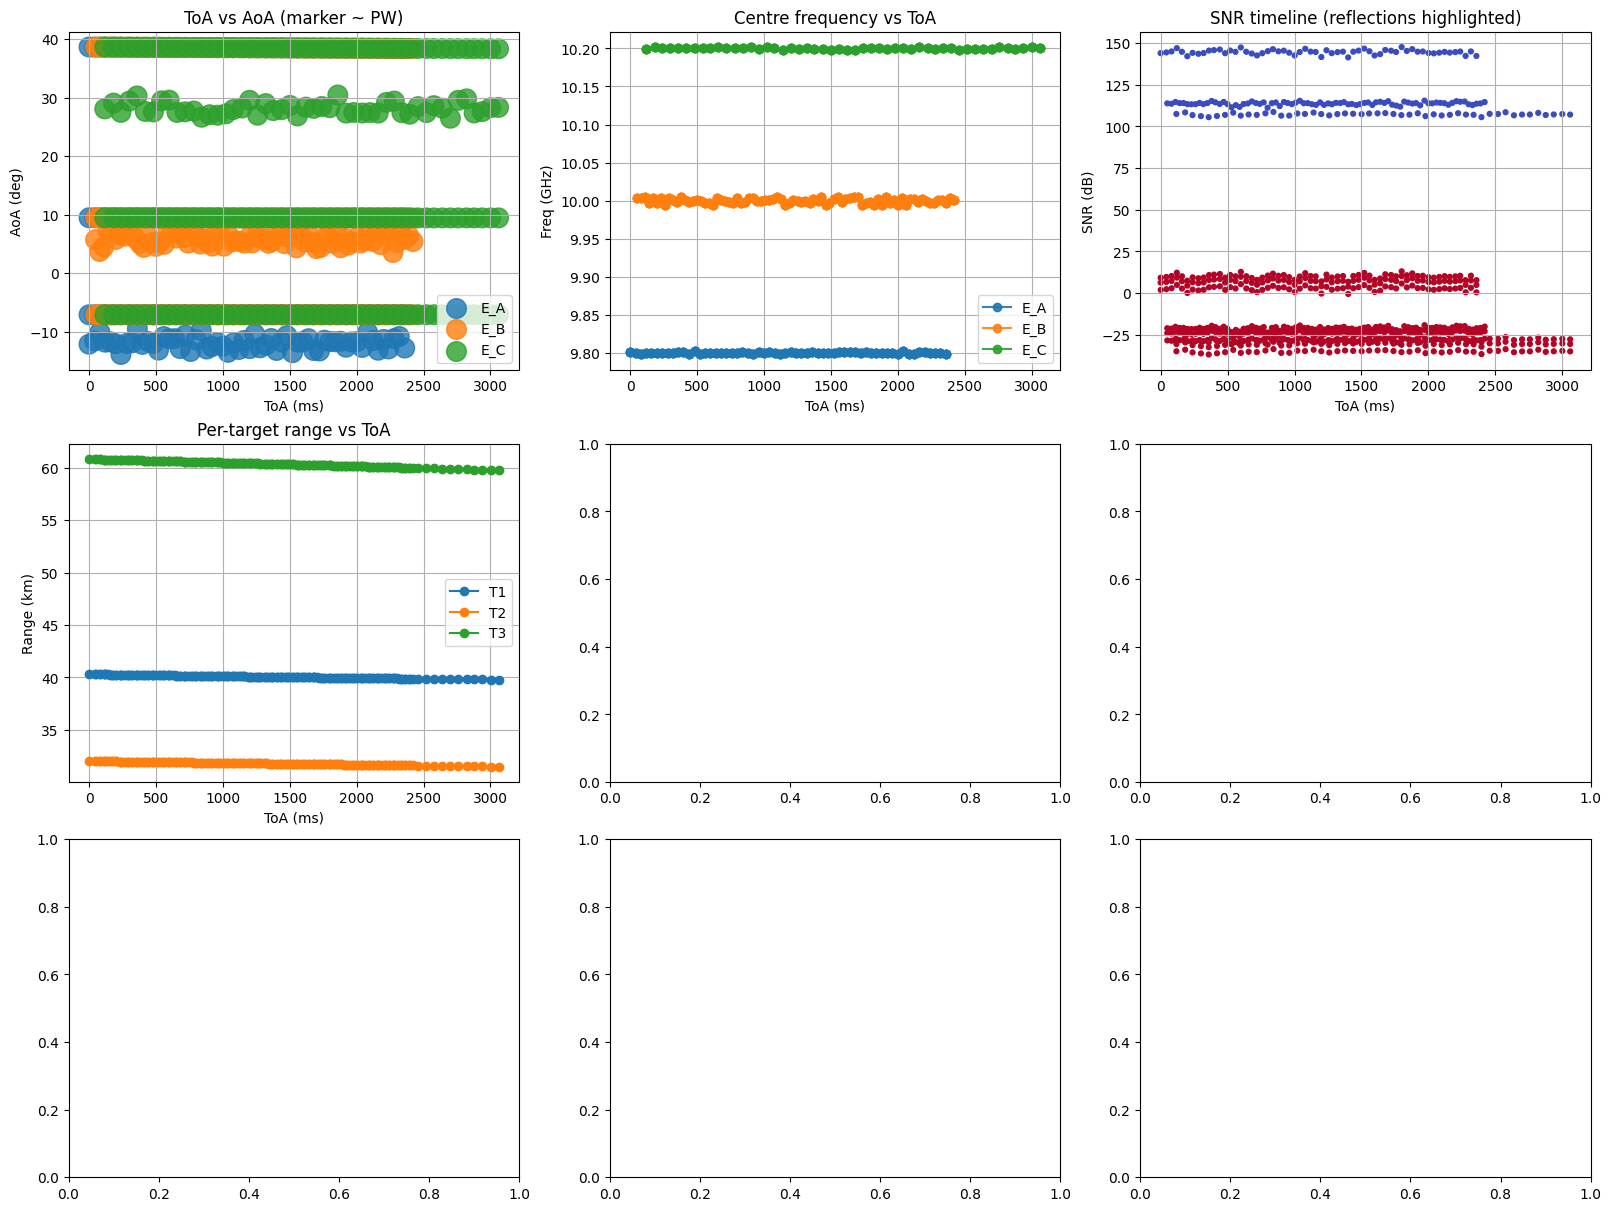

In [8]:
"""
radar_pdw_tracking_with_doppler_matched_snr_antenna.py

- Multi-emitter PDW generator.
- Multi-target moving reflections with variable velocity and acceleration.
- Doppler shift per reflected pulse (instantaneous radial velocity).
- Antenna pattern gain vs AoA (Gaussian-like).
- Matched-filter SNR using time-bandwidth product and pulse bandwidth estimate.
- Plots summarising PDWs, per-target tracks, Doppler, and matched SNR.

Run with Python 3.9+. Requires: numpy, pandas, matplotlib.
"""

from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# reproducible
np.random.seed(42)

# physical constants
c = 299792458.0           # speed of light (m/s)
k_B = 1.380649e-23        # Boltzmann constant J/K

@dataclass
class PulseDescriptor:
    emitter_id: str
    receiver_id: str
    ToA: float
    AoA: float
    PW: float
    f_c: float
    Amplitude: float
    Phase: float
    Modulation: str
    SNR_dB: float = np.nan
    Matched_SNR_dB: float = np.nan
    Range_m: float = np.nan
    Pr_W: float = np.nan
    Noise_W: float = np.nan
    Doppler_Hz: float = np.nan
    Source: str = 'direct'  # 'direct' or 'reflected'

class RadarPDWGenerator:
    def __init__(self, receiver_id='R1', receiver_pos=(0.0, 0.0),
                 noise_temp=290.0, noise_figure_dB=4.0,
                 rx_beamwidth_deg=30.0, rx_max_gain_dBi=35.0):
        self.receiver_id = receiver_id
        self.receiver_pos = np.array(receiver_pos, dtype=float)
        self.noise_temp = noise_temp
        self.noise_figure_dB = noise_figure_dB
        self.rx_beamwidth_deg = rx_beamwidth_deg
        self.rx_max_gain_dBi = rx_max_gain_dBi

    def _jittered_times(self, start, n, pri, jitter_frac=0.05):
        base = start + np.arange(n) * pri
        jitter = (np.random.uniform(-1, 1, size=n) * pri * jitter_frac)
        return base + jitter

    def generate_pulse_train(self, emitter_id: str, mode: str='pulsed',
                             n_pulses: int=50, start_time: float=0.0, pri: float=0.05,
                             pw_mean: float=1e-4, pw_jitter_frac: float=0.2,
                             fc_mean: float=10e9, fc_jitter: float=1e6,
                             aoa_mean: float=0.0, aoa_jitter: float=1.0,
                             amp_mean: float=1.0, amp_jitter_frac: float=0.2,
                             phase_jitter: float=np.pi):
        if mode == 'CW':
            times = self._jittered_times(start_time, n_pulses, pri, jitter_frac=0.5)
            pws = np.full(n_pulses, pw_mean * 0.1)
            modulation = 'CW'
        else:
            times = self._jittered_times(start_time, n_pulses, pri)
            pws = pw_mean * (1 + pw_jitter_frac * np.random.randn(n_pulses))
            pws = np.clip(pws, pw_mean * 0.05, pw_mean * 5)
        aoas = aoa_mean + aoa_jitter * np.random.randn(n_pulses)
        amps = amp_mean * np.abs(1 + amp_jitter_frac * np.random.randn(n_pulses))
        phases = np.random.uniform(-phase_jitter, phase_jitter, size=n_pulses)

        if mode == 'pulsed':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = 'pulsed'
        elif mode == 'freq_hop':
            channels = fc_mean + np.linspace(-5*fc_jitter, 5*fc_jitter, 8)
            fcs = np.random.choice(channels, size=n_pulses)
            modulation = 'freq_hop'
        elif mode == 'chirp':
            chirp_bw = 20e6
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = f'chirp_bw={int(chirp_bw)}'
        elif mode == 'phase_code':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            phases = np.random.choice([0.0, np.pi], size=n_pulses)
            modulation = 'phase_code(BPSK)'
        elif mode == 'CW':
            fcs = np.full(n_pulses, fc_mean)
            amps = np.full(n_pulses, amp_mean)
            modulation = 'CW'
        else:
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = str(mode)

        records = []
        for i in range(n_pulses):
            pdw = PulseDescriptor(
                emitter_id=emitter_id,
                receiver_id=self.receiver_id,
                ToA=float(times[i]),
                AoA=float(aoas[i]),
                PW=float(pws[i]),
                f_c=float(fcs[i]),
                Amplitude=float(amps[i]),
                Phase=float(phases[i]),
                Modulation=modulation,
                Source='direct'
            )
            records.append(pdw.__dict__)
        return pd.DataFrame.from_records(records)

    def combine_emitters(self, df_list):
        return pd.concat(df_list, ignore_index=True).sort_values('ToA').reset_index(drop=True)

    # antenna pattern: Gaussian-like around boresight=0 deg
    def rx_antenna_gain_linear(self, aoa_deg, beamwidth_deg=None, max_gain_dBi=None):
        if beamwidth_deg is None:
            beamwidth_deg = self.rx_beamwidth_deg
        if max_gain_dBi is None:
            max_gain_dBi = self.rx_max_gain_dBi
        G0 = 10 ** (max_gain_dBi / 10.0)
        # simple Gaussian fall-off: exp(-(theta/beamwidth)^2)
        theta = np.abs(((aoa_deg + 180) % 360) - 180)  # wrap to [-180,180] then abs
        gain = G0 * np.exp(-(theta / beamwidth_deg) ** 2)
        return gain

    # noise power for a given bandwidth
    def noise_power_for_B(self, B_Hz):
        NF_linear = 10 ** (self.noise_figure_dB / 10.0)
        return k_B * self.noise_temp * B_Hz * NF_linear

    # receive power for reflected pulse (monostatic radar equation) including antenna pattern at receiver
    def pdw_received_power_reflection(self, Pt_W, tx_gain_linear, rx_gain_linear_nominal, sigma_m2, R_m, fc_Hz, aoa_deg):
        lam = c / fc_Hz
        # monostatic radar eqn base Pr (before rx pattern correction)
        Pr = Pt_W * tx_gain_linear * rx_gain_linear_nominal * (lam ** 2) * sigma_m2 / ((4 * np.pi) ** 3 * (R_m ** 4))
        # apply receiver antenna pattern correction (assume rx_gain_linear_nominal is max on boresight)
        rx_pattern_factor = self.rx_antenna_gain_linear(aoa_deg) / rx_gain_linear_nominal
        Pr = Pr * rx_pattern_factor
        return Pr

    # compute doppler shift for monostatic reflection
    def compute_doppler(self, v_vec, pos_vec):
        # v_vec: target velocity vector (vx,vy); pos_vec: target position vector relative to receiver
        R = np.linalg.norm(pos_vec)
        if R <= 0:
            return 0.0, 0.0
        u = pos_vec / R
        range_rate = np.dot(v_vec, u)  # positive if moving away
        # doppler: f_d = -2 * range_rate / c * f_c  (negative for receding if we want shift sign)
        return range_rate, -2.0 * range_rate / c

    # Estimate pulse bandwidth from modulation and PW
    def estimate_bandwidth(self, pdw_row):
        pw = pdw_row['PW']
        mod = str(pdw_row['Modulation'])
        # default: bandwidth ~ 1/PW (rectangular)
        B = 1.0 / max(pw, 1e-9)
        # override for chirp
        if 'chirp_bw=' in mod:
            try:
                bw = float(mod.split('chirp_bw=')[1].split()[0])
                B = max(B, bw)
            except Exception:
                pass
        # freq-hop is wide across channels; approximate modest BW
        if 'freq_hop' in mod:
            B = max(B, 5.0e6)
        return B

    # add SNR and matched-filter SNR and Doppler to DataFrame (works on combined DF that may include reflected pulses)
    def add_snr_and_doppler(self, df, tx_power_W=100.0, tx_gain_dBi=35.0, rx_gain_dBi=35.0):
        df = df.copy().reset_index(drop=True)
        Gt = 10 ** (tx_gain_dBi / 10.0)
        Gr_nom = 10 ** (rx_gain_dBi / 10.0)  # nominal max linear gain
        noise_figure_linear = 10 ** (self.noise_figure_dB / 10.0)
        # prepare containers
        Pr_list = []
        Noise_list = []
        SNR_list = []
        Matched_SNR_list = []
        Doppler_list = []
        Range_list = []
        for i, row in df.iterrows():
            pw = float(row['PW'])
            fc = float(row['f_c'])
            amp = float(row['Amplitude'])
            Pt = tx_power_W * amp
            # determine bandwidth
            B = self.estimate_bandwidth(row)
            noise_power = self.noise_power_for_B(B)
            # If reflected and has Range_m, use radar eqn
            if row.get('Source', 'direct') == 'reflected' and not np.isnan(row.get('Range_m', np.nan)):
                R = max(row['Range_m'], 1.0)
                aoa = float(row.get('AoA', 0.0))
                Pr = self.pdw_received_power_reflection(Pt, Gt, Gr_nom, sigma_m2=2.0, R_m=R, fc_Hz=fc, aoa_deg=aoa)
                # compute instantaneous range rate and doppler if velocity fields present
                # some reflected records include 'v_x','v_y' from simulation
                if 'v_x' in row and 'v_y' in row:
                    v_vec = np.array([row['v_x'], row['v_y']])
                    # position vector pos = vector from receiver to target stored maybe in 'pos_x','pos_y'
                    if 'pos_x' in row and 'pos_y' in row:
                        pos_vec = np.array([row['pos_x'], row['pos_y']])
                        range_rate, doppler_factor = self.compute_doppler(v_vec, pos_vec)
                        doppler = doppler_factor * fc
                    else:
                        range_rate = np.nan
                        doppler = np.nan
                else:
                    range_rate = np.nan
                    doppler = np.nan
                # matched-filter SNR: processing gain ~ TB = PW * B
                TB = pw * B
                matched_snr_linear = (Pr * TB) / noise_power
                snr_linear = Pr / noise_power
            else:
                # direct path: if Range known use free-space power with antenna pattern correction
                R = row.get('Range_m', np.nan)
                aoa = float(row.get('AoA', 0.0))
                if not np.isnan(R):
                    # simple free-space Rx using gains and rx pattern
                    lam = c / fc
                    # assume isotropic scatter; approximate Pr_fs
                    Pr_fs = Pt * Gt * Gr_nom * (lam ** 2) / ((4 * np.pi * R) ** 2)
                    # apply rx antenna pattern
                    Pr = Pr_fs * (self.rx_antenna_gain_linear(aoa) / Gr_nom)
                else:
                    Pr = Pt * 1e-4
                doppler = 0.0
                matched_snr_linear = (Pr * pw) / noise_power  # conservative
                snr_linear = Pr / noise_power
            Pr_list.append(float(Pr))
            Noise_list.append(float(noise_power))
            SNR_list.append(10.0 * np.log10(max(snr_linear, 1e-30)))
            Matched_SNR_list.append(10.0 * np.log10(max(matched_snr_linear, 1e-30)))
            Doppler_list.append(float(doppler) if not np.isnan(doppler) else np.nan)
            Range_list.append(float(R) if not np.isnan(R) else np.nan)

        df['Pr_W'] = Pr_list
        df['Noise_W'] = Noise_list
        df['SNR_dB'] = SNR_list
        df['Matched_SNR_dB'] = Matched_SNR_list
        df['Doppler_Hz'] = Doppler_list
        df['Range_m'] = Range_list
        return df

    # simulate reflections from tx pulses for multiple targets with kinematics (p0,v0,a)
    def simulate_target_reflections_from_tx(self, tx_df, targets):
        tx = tx_df.sort_values('ToA').reset_index(drop=True)
        records = []
        for targ in targets:
            tid = targ['id']
            p0 = np.array(targ['p0'], dtype=float)
            v0 = np.array(targ.get('v0', (0.0, 0.0)), dtype=float)
            a = np.array(targ.get('a', (0.0, 0.0)), dtype=float)
            rcs = float(targ.get('rcs', 1.0))
            for i, row in tx.iterrows():
                t_tx = float(row['ToA'])
                # kinematics: position and velocity at transmit time
                pos = p0 + v0 * t_tx + 0.5 * a * (t_tx ** 2)
                vel = v0 + a * t_tx
                range_m = np.linalg.norm(pos - self.receiver_pos)
                t_rx = t_tx + 2.0 * range_m / c
                bearing_rad = np.arctan2(pos[1] - self.receiver_pos[1], pos[0] - self.receiver_pos[0])
                aoa_deg = np.degrees(bearing_rad)
                pdw = PulseDescriptor(
                    emitter_id=row['emitter_id'],
                    receiver_id=self.receiver_id,
                    ToA=float(t_rx),
                    AoA=float(aoa_deg),
                    PW=float(row['PW']),
                    f_c=float(row['f_c']),
                    Amplitude=float(row['Amplitude']),
                    Phase=float(row['Phase']),
                    Modulation=f"refl:{row['Modulation']}",
                    Range_m=float(range_m),
                    Source='reflected'
                )
                rec = pdw.__dict__.copy()
                # attach target kinematics for later doppler calc
                rec['target_id'] = tid
                rec['pos_x'] = pos[0]; rec['pos_y'] = pos[1]
                rec['v_x'] = vel[0]; rec['v_y'] = vel[1]
                rec['rcs'] = rcs
                rec['sigma_m2'] = rcs
                records.append(rec)
        if len(records) == 0:
            cols = ['emitter_id','receiver_id','ToA','AoA','PW','f_c','Amplitude','Phase','Modulation','Range_m','Source','target_id','pos_x','pos_y','v_x','v_y','rcs','sigma_m2']
            return pd.DataFrame(columns=cols)
        return pd.DataFrame.from_records(records)

# -----------------------
# Full example with Doppler, matched SNR, antenna pattern
# -----------------------
def run_full_example():
    gen = RadarPDWGenerator(receiver_id='R1', receiver_pos=(0.0, 0.0), noise_temp=290.0, noise_figure_dB=4.0,
                            rx_beamwidth_deg=30.0, rx_max_gain_dBi=35.0)

    # Transmitters
    emitters = [
        dict(emitter_id='E_A', mode='pulsed', n_pulses=60, start_time=0.0, pri=0.04, pw_mean=150e-6, fc_mean=9.8e9, aoa_mean=-12.0, amp_mean=2.0),
        dict(emitter_id='E_B', mode='freq_hop', n_pulses=80, start_time=0.05, pri=0.03, pw_mean=120e-6, fc_mean=10.0e9, aoa_mean=6.0, amp_mean=1.2),
        dict(emitter_id='E_C', mode='chirp', n_pulses=50, start_time=0.12, pri=0.06, pw_mean=300e-6, fc_mean=10.2e9, aoa_mean=28.0, amp_mean=1.0)
    ]

    tx_dfs = [gen.generate_pulse_train(**e) for e in emitters]
    tx_all = gen.combine_emitters(tx_dfs)

    # Targets with variable velocity & acceleration (approach then recede or vice versa)
    targets = [
        {'id': 'T1', 'p0': (40000.0, -5000.0), 'v0': (-200.0, 30.0), 'a': (20.0, -5.0), 'rcs': 2.0},
        {'id': 'T2', 'p0': (25000.0, 20000.0), 'v0': (-100.0, -150.0), 'a': (0.0, 0.0), 'rcs': 1.0},
        {'id': 'T3', 'p0': (60000.0, 10000.0), 'v0': (-300.0, -80.0), 'a': (-30.0, 10.0), 'rcs': 5.0}
    ]

    # Simulate reflections
    refl_all = gen.simulate_target_reflections_from_tx(tx_all, targets)

    # Combine tx PDWs and reflections for SNR/Doppler calculation
    combined = pd.concat([tx_all, refl_all.drop(columns=['target_id','pos_x','pos_y','v_x','v_y','rcs','sigma_m2'])],
                         ignore_index=True).sort_values('ToA').reset_index(drop=True)

    # Ensure Range_m exists (nan for direct)
    combined['Range_m'] = combined.get('Range_m', np.nan)

    # Compute SNRs and Doppler for all (reflected pulses will have Raange_m)
    # For reflected pulses that carry kinematics, we need merged info from refl_all to compute doppler. So merge before compute.
    if not refl_all.empty:
        # Merge kinematic fields into combined where ToA matches (may duplicate ToA, merge on index is safer)
        refl_fields = refl_all[['ToA','pos_x','pos_y','v_x','v_y','sigma_m2','target_id','Range_m']]
        combined = combined.merge(refl_fields, on='ToA', how='left', suffixes=('','_refl'))
        # prefer Range_m from refl if present
        combined['Range_m'] = combined['Range_m_refl'].combine_first(combined['Range_m'])
    # Now compute SNR and Doppler using available pos/v where present
    combined = gen.add_snr_and_doppler(combined, tx_power_W=100.0, tx_gain_dBi=35.0, rx_gain_dBi=35.0)

    # If refl_all present, attach computed SNR/Doppler back for plotting per-target
    if not refl_all.empty:
        # join combined SNR/Doppler into refl_all on ToA (note: ToA may not be unique if multiple emitters produce same ToA; okay for this example)
        refl_all = refl_all.merge(combined[['ToA','SNR_dB','Matched_SNR_dB','Doppler_Hz','Pr_W']], on='ToA', how='left')

    # Unit conversions
    combined['ToA_ms'] = combined['ToA'] * 1e3
    combined['PW_us'] = combined['PW'] * 1e6
    combined['f_GHz'] = combined['f_c'] / 1e9
    if not refl_all.empty:
        refl_all['ToA_ms'] = refl_all['ToA'] * 1e3
        refl_all['Range_km'] = refl_all['Range_m'] / 1e3

    # -----------------------
    # Plots
    # -----------------------
    fig, axs = plt.subplots(3, 3, figsize=(16, 12), constrained_layout=True)

    # ToA vs AoA (marker PW)
    ax = axs[0,0]
    for eid, grp in combined.groupby('emitter_id'):
        ax.scatter(grp['ToA_ms'], grp['AoA'], s=np.clip(grp['PW_us']*3, 6, 200), label=eid, alpha=0.8)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('AoA (deg)'); ax.set_title('ToA vs AoA (marker ~ PW)'); ax.grid(True); ax.legend()

    # Frequency vs ToA
    ax = axs[0,1]
    for eid, grp in combined.groupby('emitter_id'):
        g = grp.sort_values('ToA')
        ax.plot(g['ToA_ms'], g['f_GHz'], marker='o', linestyle='-', label=eid, alpha=0.9)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Freq (GHz)'); ax.set_title('Centre frequency vs ToA'); ax.grid(True); ax.legend()

    # SNR timeline (matched SNR highlighted for reflected)
    ax = axs[0,2]
    ax.scatter(combined['ToA_ms'], combined['SNR_dB'], c=(combined['Source']=='reflected'), cmap='coolwarm', s=12)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('SNR (dB)'); ax.set_title('SNR timeline (reflections highlighted)'); ax.grid(True)

    # Per-target Range vs ToA (shows approach/recede)
    ax = axs[1,0]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid].sort_values('ToA') if not refl_all.empty else pd.DataFrame()
        if not refl_tid.empty:
            ax.plot(refl_tid['ToA_ms'], refl_tid['Range_km'], marker='o', linestyle='-', label=tid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Range (km)'); ax.set_title('Per-target range vs ToA'); ax.grid(True); ax.legend()

    # Per-target Doppler vs ToA
    ax = axs[1,1]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid].sort_values('ToA') if not refl_all.empty else pd.DataFrame()
        if not refl_tid.empty:
            ax.plot(refl_tid['ToA_ms'], refl_tid['Doppler_Hz'], marker='o', linestyle='-', label=tid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Doppler (Hz)'); ax.set_title('Per-target Doppler vs ToA'); ax.grid(True); ax.legend()

    # Per-target Matched SNR vs ToA
    ax = axs[1,2]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid].sort_values('ToA') if not refl_all.empty else pd.DataFrame()
        if not refl_tid.empty:
            ax.plot(refl_tid['ToA_ms'], refl_tid['Matched_SNR_dB'], marker='o', linestyle='-', label=tid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Matched SNR (dB)'); ax.set_title('Per-target matched-filter SNR vs ToA'); ax.grid(True); ax.legend()

    # PW vs ToA
    ax = axs[2,0]
    for eid, grp in combined.groupby('emitter_id'):
        ax.scatter(grp['ToA_ms'], grp['PW_us'], s=8, alpha=0.7, label=eid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('PW (µs)'); ax.set_title('Pulse width vs ToA'); ax.grid(True); ax.legend()

    # Reflected SNR vs Range (per target)
    ax = axs[2,1]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid].sort_values('Range_m') if not refl_all.empty else pd.DataFrame()
        if not refl_tid.empty:
            ax.scatter(refl_tid['Range_km'], refl_tid['SNR_dB'], label=tid, s=20)
    ax.set_xlabel('Range (km)'); ax.set_ylabel('SNR (dB)'); ax.set_title('Reflected SNR vs Range'); ax.grid(True); ax.legend()

    # Modulation timeline
    ax = axs[2,2]
    mods = combined['Modulation'].unique()
    mod_map = {m: i for i, m in enumerate(sorted(mods))}
    ax.scatter(combined['ToA_ms'], [mod_map[m] for m in combined['Modulation']], s=6)
    ax.set_yticks(list(mod_map.values())); ax.set_yticklabels(list(mod_map.keys()))
    ax.set_xlabel('ToA (ms)'); ax.set_title('Modulation timeline'); ax.grid(True)

    plt.suptitle('PDW visualisation: Doppler, matched SNR, antenna pattern')
    plt.show()

    # Print short tables
    print("\nCombined PDWs sample:")
    print(combined[['emitter_id','Source','ToA','ToA_ms','AoA','Range_m','PW','f_c','Amplitude','SNR_dB','Matched_SNR_dB','Doppler_Hz']].head(12).to_string(index=False))

    if not refl_all.empty:
        print("\nReflected PDWs sample with targets:")
        print(refl_all[['target_id','emitter_id','ToA','ToA_ms','AoA','Range_m','SNR_dB','Matched_SNR_dB','Doppler_Hz']].head(12).to_string(index=False))

    return combined, refl_all

if __name__ == '__main__':
    combined_df, reflections_df = run_full_example()


In [9]:
"""
radar_pdw_tracking_fixed.py

Multi-emitter PDW generation.
Multi-target moving reflections with velocity+acceleration.
Doppler computed at reflection creation so refl DataFrame has Doppler_Hz.
Matched-filter SNR, antenna pattern, and plots.
"""

from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# reproducible RNG
np.random.seed(42)

# constants
c = 299792458.0
k_B = 1.380649e-23

@dataclass
class PulseDescriptor:
    emitter_id: str
    receiver_id: str
    ToA: float
    AoA: float
    PW: float
    f_c: float
    Amplitude: float
    Phase: float
    Modulation: str
    Source: str = 'direct'   # 'direct' or 'reflected'
    Range_m: float = np.nan

class RadarPDWGenerator:
    def __init__(self, receiver_id='R1', receiver_pos=(0.0, 0.0),
                 noise_temp=290.0, noise_figure_dB=4.0,
                 rx_beamwidth_deg=30.0, rx_max_gain_dBi=35.0):
        self.receiver_id = receiver_id
        self.receiver_pos = np.array(receiver_pos, dtype=float)
        self.noise_temp = noise_temp
        self.noise_figure_dB = noise_figure_dB
        self.rx_beamwidth_deg = rx_beamwidth_deg
        self.rx_max_gain_dBi = rx_max_gain_dBi

    def _jittered_times(self, start, n, pri, jitter_frac=0.05):
        base = start + np.arange(n) * pri
        jitter = (np.random.uniform(-1, 1, size=n) * pri * jitter_frac)
        return base + jitter

    def generate_pulse_train(self, emitter_id: str, mode: str='pulsed',
                             n_pulses: int=50, start_time: float=0.0, pri: float=0.05,
                             pw_mean: float=1e-4, pw_jitter_frac: float=0.2,
                             fc_mean: float=10e9, fc_jitter: float=1e6,
                             aoa_mean: float=0.0, aoa_jitter: float=1.0,
                             amp_mean: float=1.0, amp_jitter_frac: float=0.2,
                             phase_jitter: float=np.pi):
        if mode == 'CW':
            times = self._jittered_times(start_time, n_pulses, pri, jitter_frac=0.5)
            pws = np.full(n_pulses, pw_mean * 0.1)
            modulation = 'CW'
        else:
            times = self._jittered_times(start_time, n_pulses, pri)
            pws = pw_mean * (1 + pw_jitter_frac * np.random.randn(n_pulses))
            pws = np.clip(pws, pw_mean * 0.05, pw_mean * 5)
        aoas = aoa_mean + aoa_jitter * np.random.randn(n_pulses)
        amps = amp_mean * np.abs(1 + amp_jitter_frac * np.random.randn(n_pulses))
        phases = np.random.uniform(-phase_jitter, phase_jitter, size=n_pulses)

        if mode == 'pulsed':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = 'pulsed'
        elif mode == 'freq_hop':
            channels = fc_mean + np.linspace(-5*fc_jitter, 5*fc_jitter, 8)
            fcs = np.random.choice(channels, size=n_pulses)
            modulation = 'freq_hop'
        elif mode == 'chirp':
            chirp_bw = 20e6
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = f'chirp_bw={int(chirp_bw)}'
        elif mode == 'phase_code':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            phases = np.random.choice([0.0, np.pi], size=n_pulses)
            modulation = 'phase_code(BPSK)'
        elif mode == 'CW':
            fcs = np.full(n_pulses, fc_mean)
            amps = np.full(n_pulses, amp_mean)
            modulation = 'CW'
        else:
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = str(mode)

        records = []
        for i in range(n_pulses):
            pdw = PulseDescriptor(
                emitter_id=emitter_id,
                receiver_id=self.receiver_id,
                ToA=float(times[i]),
                AoA=float(aoas[i]),
                PW=float(pws[i]),
                f_c=float(fcs[i]),
                Amplitude=float(amps[i]),
                Phase=float(phases[i]),
                Modulation=modulation
            )
            rec = pdw.__dict__.copy()
            rec['tx_idx'] = i  # index within that train (helpful for merging)
            records.append(rec)
        return pd.DataFrame.from_records(records)

    def combine_emitters(self, df_list):
        return pd.concat(df_list, ignore_index=True).sort_values('ToA').reset_index(drop=True)

    def rx_antenna_gain_linear(self, aoa_deg, beamwidth_deg=None, max_gain_dBi=None):
        if beamwidth_deg is None:
            beamwidth_deg = self.rx_beamwidth_deg
        if max_gain_dBi is None:
            max_gain_dBi = self.rx_max_gain_dBi
        G0 = 10 ** (max_gain_dBi / 10.0)
        theta = np.abs(((aoa_deg + 180) % 360) - 180)
        gain = G0 * np.exp(-(theta / beamwidth_deg) ** 2)
        return gain

    def noise_power_for_B(self, B_Hz):
        NF_linear = 10 ** (self.noise_figure_dB / 10.0)
        return k_B * self.noise_temp * B_Hz * NF_linear

    def estimate_bandwidth(self, pdw_row):
        pw = pdw_row['PW']
        mod = str(pdw_row['Modulation'])
        B = 1.0 / max(pw, 1e-9)
        if 'chirp_bw=' in mod:
            try:
                bw = float(mod.split('chirp_bw=')[1].split()[0])
                B = max(B, bw)
            except Exception:
                pass
        if 'freq_hop' in mod:
            B = max(B, 5.0e6)
        return B

    def pdw_received_power_reflection(self, Pt_W, tx_gain_linear, rx_gain_linear_nominal, sigma_m2, R_m, fc_Hz, aoa_deg):
        lam = c / fc_Hz
        Pr = Pt_W * tx_gain_linear * rx_gain_linear_nominal * (lam ** 2) * sigma_m2 / ((4 * np.pi) ** 3 * (R_m ** 4))
        rx_pattern_factor = self.rx_antenna_gain_linear(aoa_deg) / rx_gain_linear_nominal
        return Pr * rx_pattern_factor

    def compute_doppler_for_pos_vel(self, pos_vec, vel_vec, fc_hz):
        R = np.linalg.norm(pos_vec)
        if R <= 0:
            return 0.0, 0.0
        u = pos_vec / R
        range_rate = np.dot(vel_vec, u)  # positive if moving away
        doppler = -2.0 * range_rate / c * fc_hz
        return range_rate, doppler

    def add_snr_and_doppler(self, df, tx_power_W=100.0, tx_gain_dBi=35.0, rx_gain_dBi=35.0):
        df = df.copy().reset_index(drop=True)
        Gt = 10 ** (tx_gain_dBi / 10.0)
        Gr_nom = 10 ** (rx_gain_dBi / 10.0)
        Pr_list, Noise_list, SNR_list, Matched_list, Doppler_list, Range_list = ([] for _ in range(6))
        for _, row in df.iterrows():
            pw = float(row['PW'])
            fc = float(row['f_c'])
            amp = float(row['Amplitude'])
            Pt = tx_power_W * amp
            B = self.estimate_bandwidth(row)
            noise_power = self.noise_power_for_B(B)
            # choose reflected vs direct
            if row.get('Source', 'direct') == 'reflected' and not np.isnan(row.get('Range_m', np.nan)):
                R = max(row['Range_m'], 1.0)
                aoa = float(row.get('AoA', 0.0))
                sigma = float(row.get('sigma_m2', 1.0)) if 'sigma_m2' in row else 1.0
                Pr = self.pdw_received_power_reflection(Pt, Gt, Gr_nom, sigma, R, fc, aoa)
                # doppler: if pos_x,pos_y and v_x,v_y present compute instantaneous doppler
                if {'pos_x','pos_y','v_x','v_y'}.issubset(row.index):
                    pos = np.array([row['pos_x'], row['pos_y']])
                    vel = np.array([row['v_x'], row['v_y']])
                    _, doppler = self.compute_doppler_for_pos_vel(pos, vel, fc)
                else:
                    doppler = row.get('Doppler_Hz', np.nan)
                TB = pw * B
                matched_linear = (Pr * TB) / noise_power
                snr_linear = Pr / noise_power
            else:
                R = row.get('Range_m', np.nan)
                aoa = float(row.get('AoA', 0.0))
                if not np.isnan(R):
                    lam = c / fc
                    Pr_fs = Pt * Gt * Gr_nom * (lam ** 2) / ((4 * np.pi * R) ** 2)
                    Pr = Pr_fs * (self.rx_antenna_gain_linear(aoa) / Gr_nom)
                else:
                    Pr = Pt * 1e-4
                doppler = 0.0
                TB = pw * B
                matched_linear = (Pr * TB) / noise_power
                snr_linear = Pr / noise_power
            Pr_list.append(float(Pr))
            Noise_list.append(float(noise_power))
            SNR_list.append(10.0 * np.log10(max(snr_linear, 1e-30)))
            Matched_list.append(10.0 * np.log10(max(matched_linear, 1e-30)))
            Doppler_list.append(float(doppler) if not np.isnan(doppler) else np.nan)
            Range_list.append(float(R) if not np.isnan(R) else np.nan)
        df['Pr_W'] = Pr_list
        df['Noise_W'] = Noise_list
        df['SNR_dB'] = SNR_list
        df['Matched_SNR_dB'] = Matched_list
        df['Doppler_Hz'] = Doppler_list
        df['Range_m'] = Range_list
        return df

    def simulate_target_reflections_from_tx(self, tx_df, targets):
        tx = tx_df.reset_index().rename(columns={'index':'global_tx_idx'})
        records = []
        for targ in targets:
            tid = targ['id']
            p0 = np.array(targ['p0'], dtype=float)
            v0 = np.array(targ.get('v0', (0.0,0.0)), dtype=float)
            a = np.array(targ.get('a', (0.0,0.0)), dtype=float)
            rcs = float(targ.get('rcs', 1.0))
            for _, row in tx.iterrows():
                t_tx = float(row['ToA'])
                pos = p0 + v0 * t_tx + 0.5 * a * (t_tx ** 2)
                vel = v0 + a * t_tx


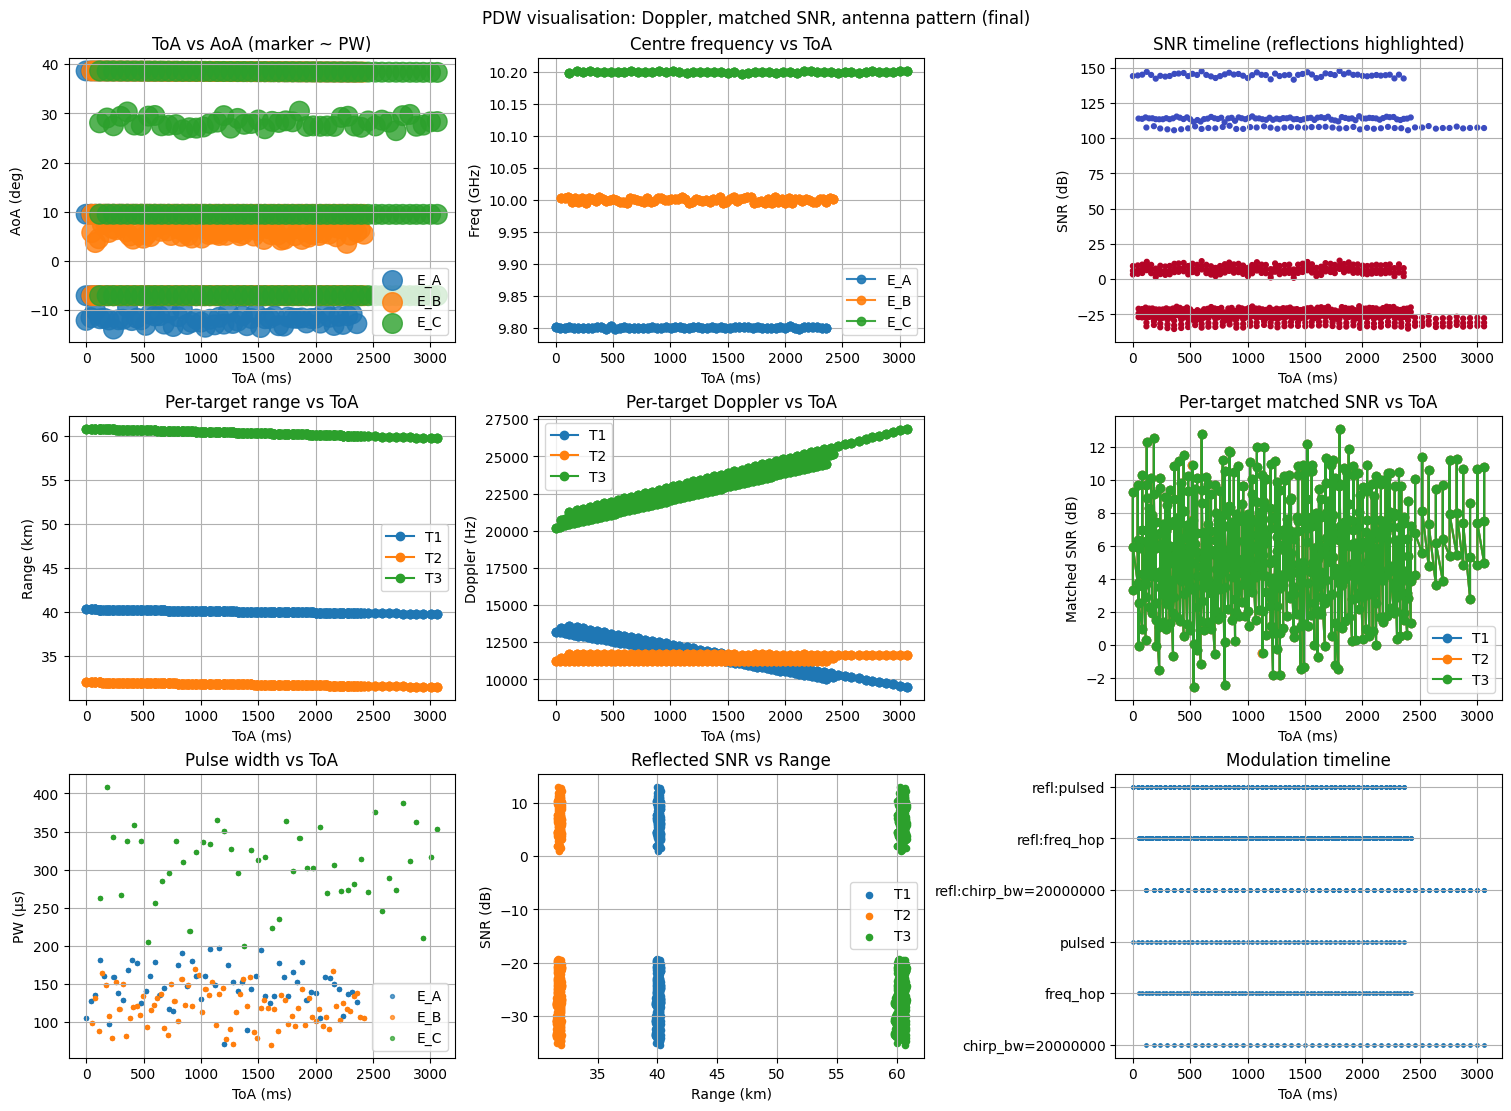


Combined PDWs (sample):
emitter_id    Source       ToA    ToA_ms        AoA      Range_m       PW          f_c  Amplitude     SNR_dB  Matched_SNR_dB   Doppler_Hz
       E_A    direct -0.000502 -0.501840 -12.161286          NaN 0.000106 9.801163e+09   2.385350 143.989171      143.989171     0.000000
       E_A reflected -0.000288 -0.288254  38.659857 32015.707399 0.000106 9.801163e+09   2.385350   3.297104        3.297104 11232.793811
       E_A reflected -0.000233 -0.232911  -7.125020 40311.390204 0.000106 9.801163e+09   2.385350   9.271956        9.271956 13220.257067
       E_A reflected -0.000096 -0.096040   9.462336 60827.780403 0.000106 9.801163e+09   2.385350   5.917304        5.917304 20208.040374
       E_A    direct  0.041803 41.802857 -11.595949          NaN 0.000128 9.800010e+09   2.165112 144.415800      144.415800     0.000000
       E_A reflected  0.042016 42.016395  38.655718 32008.439908 0.000128 9.800010e+09   2.165112   3.730242        3.730242 11231.214273
       E_

In [10]:
"""
radar_pdw_tracking_final.py

Multi-emitter PDW generation.
Multi-target moving reflections with variable velocity & acceleration.
Doppler always computed and stored in reflected PDWs.
Matched-filter SNR, antenna pattern, Pr, Noise.
Plots and sample tables.

Units: seconds, Hz, metres, degrees, Watts, dB.
"""

from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# reproducible RNG
np.random.seed(42)

# constants
c = 299792458.0           # speed of light m/s
k_B = 1.380649e-23       # Boltzmann constant J/K

@dataclass
class PulseDescriptor:
    emitter_id: str
    receiver_id: str
    ToA: float
    AoA: float
    PW: float
    f_c: float
    Amplitude: float
    Phase: float
    Modulation: str
    Source: str = 'direct'
    Range_m: float = np.nan

class RadarPDWGenerator:
    def __init__(self,
                 receiver_id='R1',
                 receiver_pos=(0.0, 0.0),
                 noise_temp=290.0,
                 noise_figure_dB=4.0,
                 rx_beamwidth_deg=30.0,
                 rx_max_gain_dBi=35.0):
        self.receiver_id = receiver_id
        self.receiver_pos = np.array(receiver_pos, dtype=float)
        self.noise_temp = noise_temp
        self.noise_figure_dB = noise_figure_dB
        self.rx_beamwidth_deg = rx_beamwidth_deg
        self.rx_max_gain_dBi = rx_max_gain_dBi

    def _jittered_times(self, start, n, pri, jitter_frac=0.05):
        base = start + np.arange(n) * pri
        jitter = (np.random.uniform(-1, 1, size=n) * pri * jitter_frac)
        return base + jitter

    def generate_pulse_train(self, emitter_id: str, mode: str='pulsed',
                             n_pulses: int=50, start_time: float=0.0, pri: float=0.05,
                             pw_mean: float=1e-4, pw_jitter_frac: float=0.2,
                             fc_mean: float=10e9, fc_jitter: float=1e6,
                             aoa_mean: float=0.0, aoa_jitter: float=1.0,
                             amp_mean: float=1.0, amp_jitter_frac: float=0.2,
                             phase_jitter: float=np.pi):
        # times & pulse widths
        if mode == 'CW':
            times = self._jittered_times(start_time, n_pulses, pri, jitter_frac=0.5)
            pws = np.full(n_pulses, pw_mean * 0.1)
        else:
            times = self._jittered_times(start_time, n_pulses, pri)
            pws = pw_mean * (1 + pw_jitter_frac * np.random.randn(n_pulses))
            pws = np.clip(pws, pw_mean * 0.05, pw_mean * 5)
        # AoA, amplitude, phase
        aoas = aoa_mean + aoa_jitter * np.random.randn(n_pulses)
        amps = amp_mean * np.abs(1 + amp_jitter_frac * np.random.randn(n_pulses))
        phases = np.random.uniform(-phase_jitter, phase_jitter, size=n_pulses)
        # centre frequencies and modulation label
        if mode == 'pulsed':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = 'pulsed'
        elif mode == 'freq_hop':
            channels = fc_mean + np.linspace(-5*fc_jitter, 5*fc_jitter, 8)
            fcs = np.random.choice(channels, size=n_pulses)
            modulation = 'freq_hop'
        elif mode == 'chirp':
            chirp_bw = 20e6
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = f'chirp_bw={int(chirp_bw)}'
        elif mode == 'phase_code':
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            phases = np.random.choice([0.0, np.pi], size=n_pulses)
            modulation = 'phase_code(BPSK)'
        elif mode == 'CW':
            fcs = np.full(n_pulses, fc_mean)
            amps = np.full(n_pulses, amp_mean)
            modulation = 'CW'
        else:
            fcs = fc_mean + np.random.randn(n_pulses) * fc_jitter
            modulation = str(mode)

        records = []
        for i in range(n_pulses):
            pdw = PulseDescriptor(
                emitter_id=emitter_id,
                receiver_id=self.receiver_id,
                ToA=float(times[i]),
                AoA=float(aoas[i]),
                PW=float(pws[i]),
                f_c=float(fcs[i]),
                Amplitude=float(amps[i]),
                Phase=float(phases[i]),
                Modulation=modulation,
                Source='direct'
            )
            rec = pdw.__dict__.copy()
            rec['tx_idx'] = i
            records.append(rec)
        return pd.DataFrame.from_records(records)

    def combine_emitters(self, df_list):
        return pd.concat(df_list, ignore_index=True).sort_values('ToA').reset_index(drop=True)

    def rx_antenna_gain_linear(self, aoa_deg, beamwidth_deg=None, max_gain_dBi=None):
        if beamwidth_deg is None:
            beamwidth_deg = self.rx_beamwidth_deg
        if max_gain_dBi is None:
            max_gain_dBi = self.rx_max_gain_dBi
        G0 = 10 ** (max_gain_dBi / 10.0)
        theta = np.abs(((aoa_deg + 180) % 360) - 180)
        gain = G0 * np.exp(-(theta / beamwidth_deg) ** 2)
        return gain

    def estimate_bandwidth(self, pw, modulation):
        B = 1.0 / max(pw, 1e-9)
        if isinstance(modulation, str) and 'chirp_bw=' in modulation:
            try:
                bw = float(modulation.split('chirp_bw=')[1].split()[0])
                B = max(B, bw)
            except Exception:
                pass
        if isinstance(modulation, str) and 'freq_hop' in modulation:
            B = max(B, 5.0e6)
        return B

    def noise_power_for_B(self, B_Hz):
        NF_linear = 10 ** (self.noise_figure_dB / 10.0)
        return k_B * self.noise_temp * B_Hz * NF_linear

    def pdw_received_power_reflection(self, Pt_W, Gt_lin, Gr_lin_nom, sigma_m2, R_m, fc_Hz, aoa_deg):
        lam = c / fc_Hz
        Pr = Pt_W * Gt_lin * Gr_lin_nom * (lam ** 2) * sigma_m2 / ((4 * np.pi) ** 3 * (R_m ** 4))
        rx_pattern_factor = self.rx_antenna_gain_linear(aoa_deg) / Gr_lin_nom
        return Pr * rx_pattern_factor

    def compute_range_rate_and_doppler(self, pos_vec, vel_vec, fc_hz):
        R = np.linalg.norm(pos_vec)
        if R <= 0:
            return 0.0, 0.0
        u = pos_vec / R
        range_rate = np.dot(vel_vec, u)  # positive if moving away
        doppler = -2.0 * range_rate / c * fc_hz
        return range_rate, doppler

    def add_snr_and_doppler(self, df, tx_power_W=100.0, tx_gain_dBi=35.0, rx_gain_dBi=35.0):
        df = df.copy().reset_index(drop=True)
        Gt = 10 ** (tx_gain_dBi / 10.0)
        Gr_nom = 10 ** (rx_gain_dBi / 10.0)
        Pr_list = []
        Noise_list = []
        SNR_list = []
        Matched_list = []
        Doppler_list = []
        Range_list = []
        for _, row in df.iterrows():
            pw = float(row['PW'])
            fc = float(row['f_c'])
            amp = float(row['Amplitude'])
            Pt = tx_power_W * amp
            B = self.estimate_bandwidth(pw, row.get('Modulation', ''))
            noise_power = self.noise_power_for_B(B)
            # reflected path
            if row.get('Source', 'direct') == 'reflected' and not np.isnan(row.get('Range_m', np.nan)):
                R = max(row['Range_m'], 1.0)
                aoa = float(row.get('AoA', 0.0))
                sigma = float(row.get('sigma_m2', 1.0)) if 'sigma_m2' in row else 1.0
                Pr = self.pdw_received_power_reflection(Pt, Gt, Gr_nom, sigma, R, fc, aoa)
                # if pos/v present compute doppler
                if {'pos_x','pos_y','v_x','v_y'}.issubset(row.index):
                    pos = np.array([row['pos_x'], row['pos_y']])
                    vel = np.array([row['v_x'], row['v_y']])
                    _, doppler = self.compute_range_rate_and_doppler(pos - self.receiver_pos, vel, fc)
                else:
                    doppler = row.get('Doppler_Hz', np.nan)
                TB = pw * B
                matched_linear = (Pr * TB) / noise_power
                snr_linear = Pr / noise_power
            else:
                R = row.get('Range_m', np.nan)
                aoa = float(row.get('AoA', 0.0))
                if not np.isnan(R):
                    lam = c / fc
                    Pr_fs = Pt * Gt * Gr_nom * (lam ** 2) / ((4 * np.pi * R) ** 2)
                    Pr = Pr_fs * (self.rx_antenna_gain_linear(aoa) / Gr_nom)
                else:
                    Pr = Pt * 1e-4
                doppler = 0.0
                TB = pw * B
                matched_linear = (Pr * TB) / noise_power
                snr_linear = Pr / noise_power
            Pr_list.append(float(Pr))
            Noise_list.append(float(noise_power))
            SNR_list.append(10.0 * np.log10(max(snr_linear, 1e-30)))
            Matched_list.append(10.0 * np.log10(max(matched_linear, 1e-30)))
            Doppler_list.append(float(doppler) if not np.isnan(doppler) else np.nan)
            Range_list.append(float(R) if not np.isnan(R) else np.nan)
        df['Pr_W'] = Pr_list
        df['Noise_W'] = Noise_list
        df['SNR_dB'] = SNR_list
        df['Matched_SNR_dB'] = Matched_list
        df['Doppler_Hz'] = Doppler_list
        df['Range_m'] = Range_list
        return df

    def simulate_target_reflections_from_tx(self, tx_df, targets):
        """
        tx_df: DataFrame of transmitted PDWs (must include 'tx_idx' and 'emitter_id' fields)
        targets: list of dicts with keys:
          - id, p0 (x,y), v0 (vx,vy), a (ax,ay), rcs
        Returns DataFrame of reflected PDWs with Doppler_Hz always present and kinematic fields.
        """
        tx = tx_df.reset_index().rename(columns={'index':'global_tx_idx'})
        records = []
        for targ in targets:
            tid = targ['id']
            p0 = np.array(targ['p0'], dtype=float)
            v0 = np.array(targ.get('v0', (0.0,0.0)), dtype=float)
            a = np.array(targ.get('a', (0.0,0.0)), dtype=float)
            rcs = float(targ.get('rcs', 1.0))
            for _, row in tx.iterrows():
                t_tx = float(row['ToA'])
                # kinematics at transmit time
                pos = p0 + v0 * t_tx + 0.5 * a * (t_tx ** 2)
                vel = v0 + a * t_tx
                vec = pos - self.receiver_pos
                R = np.linalg.norm(vec)
                t_rx = t_tx + 2.0 * R / c
                bearing_rad = np.arctan2(vec[1], vec[0])
                aoa_deg = np.degrees(bearing_rad)
                # compute doppler factor and Doppler_Hz
                range_rate, doppler_factor = self.compute_range_rate_and_doppler(vec, vel, row['f_c'])
                doppler_hz = doppler_factor  # compute_range_rate_and_doppler returns doppler already in Hz (function returns doppler = -2*vr/c*fc)
                # build record — ensure Doppler_Hz always present and ToA_ms included
                rec = {
                    'emitter_id': row['emitter_id'],
                    'receiver_id': self.receiver_id,
                    'ToA': float(t_rx),
                    'ToA_ms': float(t_rx * 1e3),
                    'AoA': float(aoa_deg),
                    'PW': float(row['PW']),
                    'f_c': float(row['f_c']),
                    'Amplitude': float(row['Amplitude']),
                    'Phase': float(row['Phase']),
                    'Modulation': f"refl:{row['Modulation']}",
                    'Source': 'reflected',
                    'Range_m': float(R),
                    'target_id': tid,
                    'pos_x': float(pos[0]), 'pos_y': float(pos[1]),
                    'v_x': float(vel[0]), 'v_y': float(vel[1]),
                    'sigma_m2': rcs,
                    'global_tx_idx': int(row['global_tx_idx']),
                    'tx_idx': int(row['tx_idx']),
                    'Doppler_Hz': float(doppler_hz)
                }
                records.append(rec)
        if len(records) == 0:
            return pd.DataFrame()
        return pd.DataFrame.from_records(records)

# -----------------------
# Full run: setup, simulate, compute, plot
# -----------------------
def run_full():
    gen = RadarPDWGenerator(receiver_id='R1', receiver_pos=(0.0, 0.0),
                            noise_temp=290.0, noise_figure_dB=4.0,
                            rx_beamwidth_deg=30.0, rx_max_gain_dBi=35.0)

    # transmitters
    emitters = [
        dict(emitter_id='E_A', mode='pulsed', n_pulses=60, start_time=0.0, pri=0.04, pw_mean=150e-6, fc_mean=9.8e9, aoa_mean=-12.0, amp_mean=2.0),
        dict(emitter_id='E_B', mode='freq_hop', n_pulses=80, start_time=0.05, pri=0.03, pw_mean=120e-6, fc_mean=10.0e9, aoa_mean=6.0, amp_mean=1.2),
        dict(emitter_id='E_C', mode='chirp', n_pulses=50, start_time=0.12, pri=0.06, pw_mean=300e-6, fc_mean=10.2e9, aoa_mean=28.0, amp_mean=1.0)
    ]
    tx_dfs = [gen.generate_pulse_train(**e) for e in emitters]
    tx_all = gen.combine_emitters(tx_dfs)

    # targets: variable velocity & acceleration (some approach then recede)
    targets = [
        {'id':'T1','p0':(40000.0,-5000.0),'v0':(-200.0,30.0),'a':(20.0,-5.0),'rcs':2.0},
        {'id':'T2','p0':(25000.0,20000.0),'v0':(-100.0,-150.0),'a':(0.0,0.0),'rcs':1.0},
        {'id':'T3','p0':(60000.0,10000.0),'v0':(-300.0,-80.0),'a':(-30.0,10.0),'rcs':5.0}
    ]

    # simulate reflections (Doppler_Hz included)
    refl_all = gen.simulate_target_reflections_from_tx(tx_all, targets)

    # ensure ToA_ms exists in tx_all
    tx_all['ToA_ms'] = tx_all['ToA'] * 1e3

    # Combine tx (direct) and reflected PDWs for SNR/doppler computation.
    # Keep refl_all kinematic columns; create combined for global processing.
    combined_direct = tx_all.copy()
    combined_reflected = refl_all.copy() if not refl_all.empty else pd.DataFrame()
    # create combined df that includes reflected kinematic fields (so add_snr_and_doppler can use them)
    if not combined_reflected.empty:
        combined = pd.concat([combined_direct, combined_reflected.drop(columns=['target_id'])], ignore_index=True).sort_values('ToA').reset_index(drop=True)
    else:
        combined = combined_direct.copy()

    # Compute SNR and Doppler where possible
    combined = gen.add_snr_and_doppler(combined, tx_power_W=100.0, tx_gain_dBi=35.0, rx_gain_dBi=35.0)

    # Merge computed SNR/Doppler back to refl_all using emitter_id + tx_idx + global_tx_idx where present
    if not refl_all.empty:
        # ensure keys exist on both sides
        merged_keys = ['emitter_id','tx_idx','global_tx_idx'] if 'global_tx_idx' in combined.columns else ['emitter_id','tx_idx']
        # prepare combined subset for merge
        comb_subset = combined[['emitter_id','tx_idx','global_tx_idx','SNR_dB','Matched_SNR_dB','Pr_W','Doppler_Hz','Range_m']].drop_duplicates()
        # merge (use how='left')
        refl_all = refl_all.merge(comb_subset, on=['emitter_id','tx_idx','global_tx_idx'], how='left', suffixes=('','_calc'))

    # Ensure plotting columns exist
    combined['ToA_ms'] = combined['ToA'] * 1e3
    combined['PW_us'] = combined['PW'] * 1e6
    combined['f_GHz'] = combined['f_c'] / 1e9
    if not refl_all.empty:
        if 'ToA_ms' not in refl_all.columns:
            refl_all['ToA_ms'] = refl_all['ToA'] * 1e3
        if 'Doppler_Hz' not in refl_all.columns:
            refl_all['Doppler_Hz'] = np.nan
        if 'SNR_dB' not in refl_all.columns:
            refl_all['SNR_dB'] = np.nan
        if 'Matched_SNR_dB' not in refl_all.columns:
            refl_all['Matched_SNR_dB'] = np.nan
        refl_all['Range_km'] = refl_all['Range_m'] / 1e3

    # -----------------------
    # Plots
    # -----------------------
    fig, axs = plt.subplots(3, 3, figsize=(15, 11), constrained_layout=True)

    # ToA vs AoA, marker size ~ PW, colour by emitter
    ax = axs[0,0]
    for eid, grp in combined.groupby('emitter_id'):
        ax.scatter(grp['ToA_ms'], grp['AoA'], s=np.clip(grp['PW_us']*3, 6, 200), label=eid, alpha=0.8)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('AoA (deg)'); ax.set_title('ToA vs AoA (marker ~ PW)'); ax.grid(True); ax.legend()

    # Centre freq vs ToA
    ax = axs[0,1]
    for eid, grp in combined.groupby('emitter_id'):
        g = grp.sort_values('ToA')
        ax.plot(g['ToA_ms'], g['f_GHz'], marker='o', linestyle='-', label=eid, alpha=0.9)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Freq (GHz)'); ax.set_title('Centre frequency vs ToA'); ax.grid(True); ax.legend()

    # SNR timeline (reflections highlighted)
    ax = axs[0,2]
    ax.scatter(combined['ToA_ms'], combined['SNR_dB'], c=(combined['Source']=='reflected'), cmap='coolwarm', s=12)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('SNR (dB)'); ax.set_title('SNR timeline (reflections highlighted)'); ax.grid(True)

    # Per-target Range vs ToA
    ax = axs[1,0]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid].sort_values('ToA') if not refl_all.empty else pd.DataFrame()
        if not refl_tid.empty:
            ax.plot(refl_tid['ToA_ms'], refl_tid['Range_km'], marker='o', linestyle='-', label=tid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Range (km)'); ax.set_title('Per-target range vs ToA'); ax.grid(True); ax.legend()

    # Per-target Doppler vs ToA
    ax = axs[1,1]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid].sort_values('ToA') if not refl_all.empty else pd.DataFrame()
        if not refl_tid.empty:
            ax.plot(refl_tid['ToA_ms'], refl_tid['Doppler_Hz'], marker='o', linestyle='-', label=tid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Doppler (Hz)'); ax.set_title('Per-target Doppler vs ToA'); ax.grid(True); ax.legend()

    # Per-target matched SNR vs ToA
    ax = axs[1,2]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid].sort_values('ToA') if not refl_all.empty else pd.DataFrame()
        if not refl_tid.empty:
            ax.plot(refl_tid['ToA_ms'], refl_tid['Matched_SNR_dB'], marker='o', linestyle='-', label=tid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('Matched SNR (dB)'); ax.set_title('Per-target matched SNR vs ToA'); ax.grid(True); ax.legend()

    # PW vs ToA
    ax = axs[2,0]
    for eid, grp in combined.groupby('emitter_id'):
        ax.scatter(grp['ToA_ms'], grp['PW_us'], s=8, alpha=0.7, label=eid)
    ax.set_xlabel('ToA (ms)'); ax.set_ylabel('PW (µs)'); ax.set_title('Pulse width vs ToA'); ax.grid(True); ax.legend()

    # Reflected SNR vs Range
    ax = axs[2,1]
    for t in targets:
        tid = t['id']
        refl_tid = refl_all[refl_all['target_id']==tid] if not refl_all.empty else pd.DataFrame()
        if not refl_tid.empty:
            ax.scatter(refl_tid['Range_km'], refl_tid['SNR_dB'], label=tid, s=20)
    ax.set_xlabel('Range (km)'); ax.set_ylabel('SNR (dB)'); ax.set_title('Reflected SNR vs Range'); ax.grid(True); ax.legend()

    # Modulation timeline
    ax = axs[2,2]
    mods = combined['Modulation'].unique()
    mod_map = {m:i for i,m in enumerate(sorted(mods))}
    ax.scatter(combined['ToA_ms'], [mod_map[m] for m in combined['Modulation']], s=6)
    ax.set_yticks(list(mod_map.values())); ax.set_yticklabels(list(mod_map.keys()))
    ax.set_xlabel('ToA (ms)'); ax.set_title('Modulation timeline'); ax.grid(True)

    plt.suptitle('PDW visualisation: Doppler, matched SNR, antenna pattern (final)')
    plt.show()

    # Print short samples
    print("\nCombined PDWs (sample):")
    cols = ['emitter_id','Source','ToA','ToA_ms','AoA','Range_m','PW','f_c','Amplitude','SNR_dB','Matched_SNR_dB','Doppler_Hz']
    print(combined[cols].head(12).to_string(index=False))

    if not refl_all.empty:
        print("\nReflected PDWs (sample) with targets:")
        sample_cols = ['target_id','emitter_id','ToA','ToA_ms','AoA','Range_m','SNR_dB','Matched_SNR_dB','Doppler_Hz']
        # ensure columns exist
        for c in sample_cols:
            if c not in refl_all.columns:
                refl_all[c] = np.nan
        print(refl_all[sample_cols].head(12).to_string(index=False))

    return combined, refl_all

if __name__ == '__main__':
    combined_df, reflections_df = run_full()


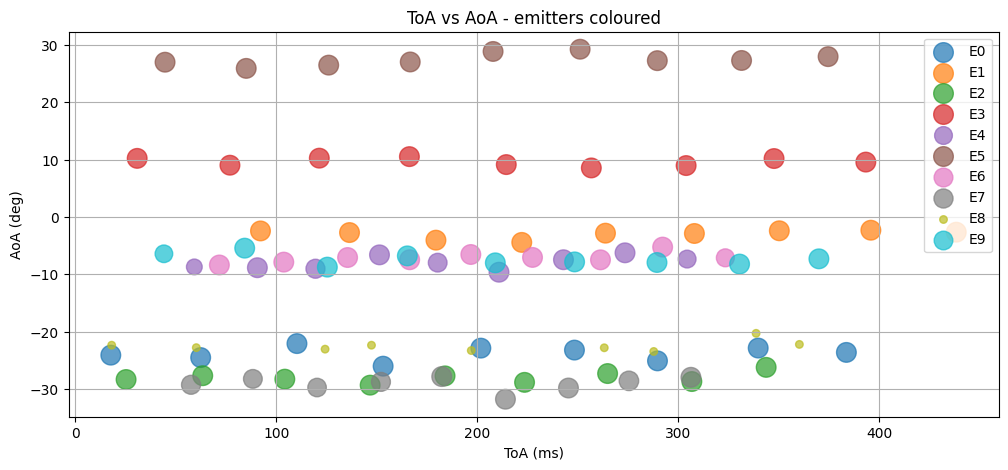

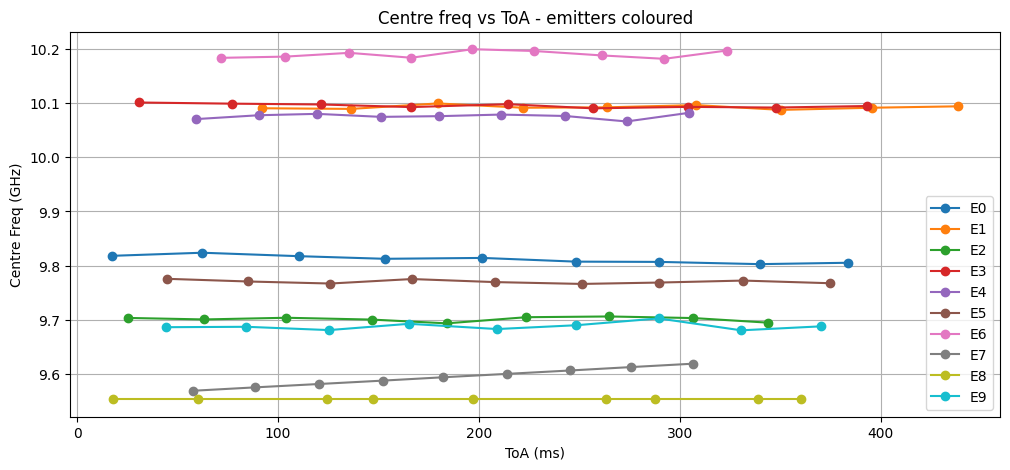

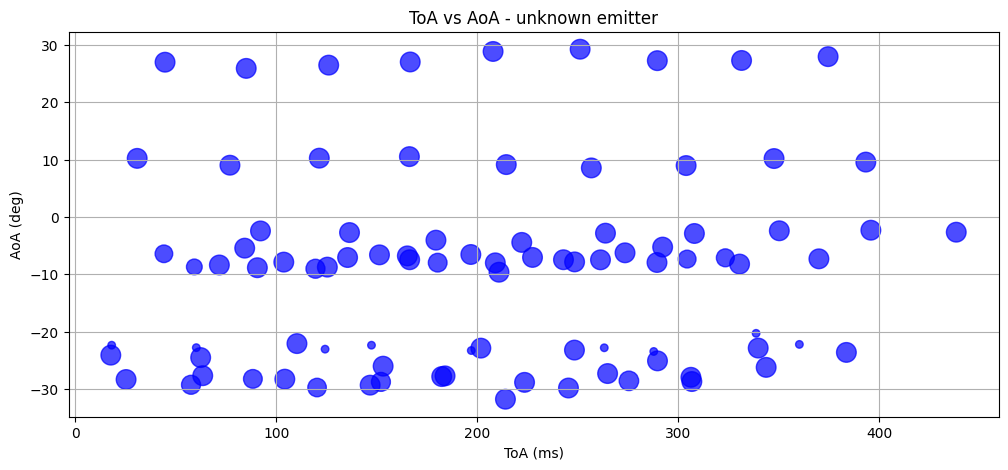

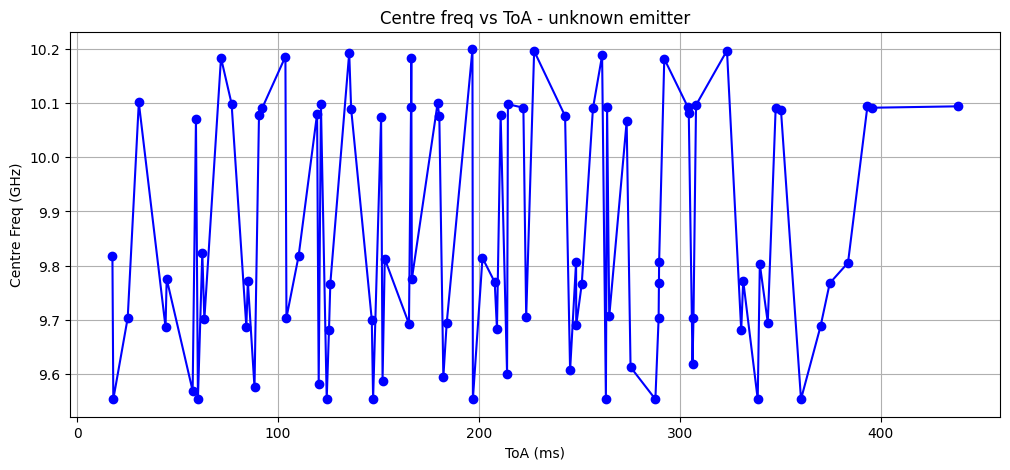

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

np.random.seed(42)

c = 299792458.0
k_B = 1.380649e-23
n= np.random.randint(3, 25)

@dataclass
class PulseDescriptor:
    emitter_id: str
    receiver_id: str
    ToA: float
    AoA: float
    PW: float
    f_c: float
    Amplitude: float
    Phase: float
    Modulation: str
    Source: str = 'direct'
    Range_m: float = np.nan

class RadarPDWGenerator:
    def __init__(self, receiver_id='R1', receiver_pos=(0.0,0.0), noise_temp=290.0,
                 noise_figure_dB=4.0, rx_beamwidth_deg=30.0, rx_max_gain_dBi=35.0):
        self.receiver_id = receiver_id
        self.receiver_pos = np.array(receiver_pos)
        self.noise_temp = noise_temp
        self.noise_figure_dB = noise_figure_dB
        self.rx_beamwidth_deg = rx_beamwidth_deg
        self.rx_max_gain_dBi = rx_max_gain_dBi

    def _jittered_times(self,start,n,pri,jitter_frac=0.05):
        base = start + np.arange(n) * pri
        jitter = (np.random.uniform(-1,1,n) * pri * jitter_frac)
        return base + jitter

    def generate_pulse_train(self, emitter_id:str, mode='pulsed',
                             n_pulses=50, start_time=0.0, pri=0.05,
                             pw_mean=1e-4, pw_jitter_frac=0.2,
                             fc_mean=10e9, fc_jitter=1e6,
                             aoa_mean=0.0, aoa_jitter=1.0,
                             amp_mean=1.0, amp_jitter_frac=0.2,
                             phase_jitter=np.pi):
        if mode=='CW':
            times = self._jittered_times(start_time,n,pri,jitter_frac=0.5)
            pws = np.full(n, pw_mean*0.1)
        else:
            times = self._jittered_times(start_time,n,pri)
            pws = pw_mean*(1 + pw_jitter_frac*np.random.randn(n))
            pws = np.clip(pws, pw_mean*0.05, pw_mean*5)
        aoas = aoa_mean + aoa_jitter*np.random.randn(n)
        amps = amp_mean * np.abs(1 + amp_jitter_frac*np.random.randn(n))
        phases = np.random.uniform(-phase_jitter, phase_jitter, size=n)
        if mode=='pulsed':
            fcs = fc_mean + np.random.randn(n)*fc_jitter
        elif mode=='freq_hop':
            fcs = fc_mean + np.linspace(-5*fc_jitter,5*fc_jitter,n)
        elif mode=='chirp':
            fcs = fc_mean + np.random.randn(n)*fc_jitter
        elif mode=='phase_code':
            fcs = fc_mean + np.random.randn(n)*fc_jitter
            phases = np.random.choice([0.0,np.pi],size=n)
        else:
            fcs = np.full(n, fc_mean)
        records = []
        for i in range(n):
            rec = PulseDescriptor(emitter_id,self.receiver_id,times[i],aoas[i],pws[i],fcs[i],
                                  amps[i],phases[i],mode)
            d = rec.__dict__.copy()
            d['tx_idx'] = i
            records.append(d)
        return pd.DataFrame.from_records(records)

    def combine_emitters(self, df_list):
        return pd.concat(df_list,ignore_index=True).sort_values('ToA').reset_index(drop=True)

# ------------------------
# Simulation parameters
# ------------------------
N_emitters = 10
emitter_ids = [f"E{i}" for i in range(N_emitters)]
mod_types = ['pulsed','chirp','freq_hop','phase_code','CW']

gen = RadarPDWGenerator()

tx_dfs = []
for eid in emitter_ids:
    mode = np.random.choice(mod_types)
    n_pulses = np.random.randint(40,80)
    start_time = np.random.rand()*0.1
    pri = 0.03 + 0.02*np.random.rand()
    pw_mean = 100e-6 + np.random.rand()*200e-6
    fc_mean = 9.5e9 + np.random.rand()*0.7e9
    aoa_mean = -30 + np.random.rand()*60
    amp_mean = 1.0 + np.random.rand()*2.0
    df = gen.generate_pulse_train(eid, mode,n_pulses,start_time,pri,pw_mean,pw_jitter_frac=0.2,
                                  fc_mean=fc_mean,fc_jitter=5e6,aoa_mean=aoa_mean,amp_mean=amp_mean)
    tx_dfs.append(df)

tx_all = gen.combine_emitters(tx_dfs)
tx_all['ToA_ms'] = tx_all['ToA']*1e3
tx_all['PW_us'] = tx_all['PW']*1e6
tx_all['f_GHz'] = tx_all['f_c']/1e9

# ------------------------
# Plot set 1: emitters distinguished by colour
# ------------------------
plt.figure(figsize=(12,5))
for eid,grp in tx_all.groupby('emitter_id'):
    plt.scatter(grp['ToA_ms'],grp['AoA'],s=np.clip(grp['PW_us']*2,5,200),label=eid,alpha=0.7)
plt.xlabel('ToA (ms)'); plt.ylabel('AoA (deg)'); plt.title('ToA vs AoA - emitters coloured'); plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for eid,grp in tx_all.groupby('emitter_id'):
    plt.plot(grp['ToA_ms'],grp['f_GHz'],marker='o',linestyle='-',label=eid)
plt.xlabel('ToA (ms)'); plt.ylabel('Centre Freq (GHz)'); plt.title('Centre freq vs ToA - emitters coloured'); plt.grid(True); plt.legend()
plt.show()

# ------------------------
# Plot set 2: unknown emitter (all same colour)
# ------------------------
plt.figure(figsize=(12,5))
plt.scatter(tx_all['ToA_ms'],tx_all['AoA'],s=np.clip(tx_all['PW_us']*2,5,200),c='blue',alpha=0.7)
plt.xlabel('ToA (ms)'); plt.ylabel('AoA (deg)'); plt.title('ToA vs AoA - unknown emitter'); plt.grid(True); 
plt.show()

plt.figure(figsize=(12,5))
plt.plot(tx_all['ToA_ms'],tx_all['f_GHz'],marker='o',linestyle='-',color='blue')
plt.xlabel('ToA (ms)'); plt.ylabel('Centre Freq (GHz)'); plt.title('Centre freq vs ToA - unknown emitter'); plt.grid(True)
plt.show()


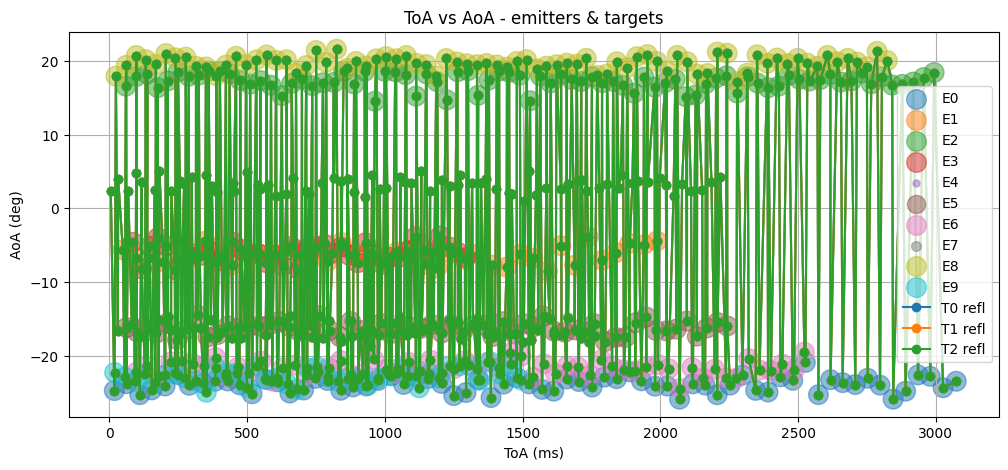

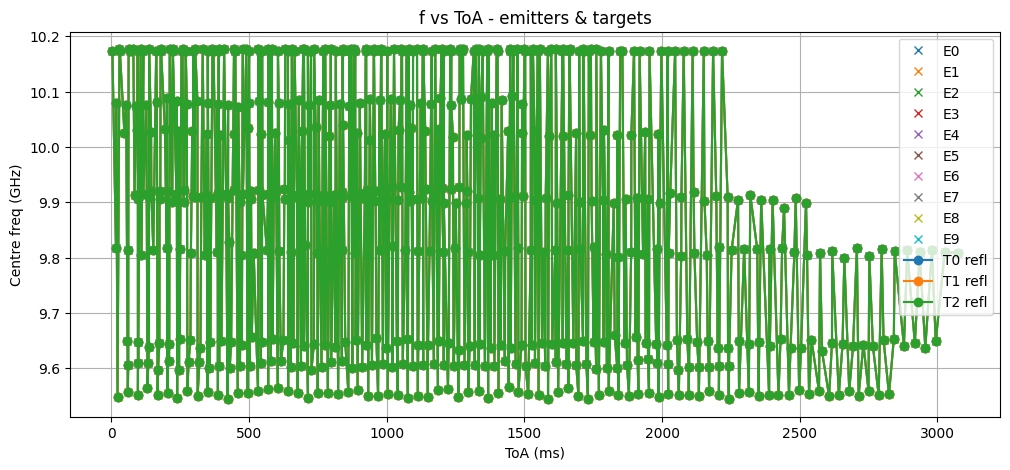

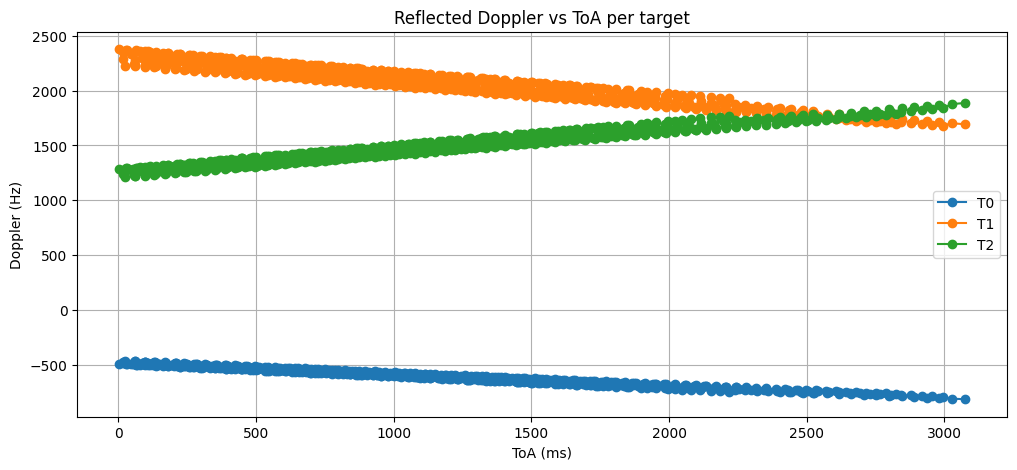

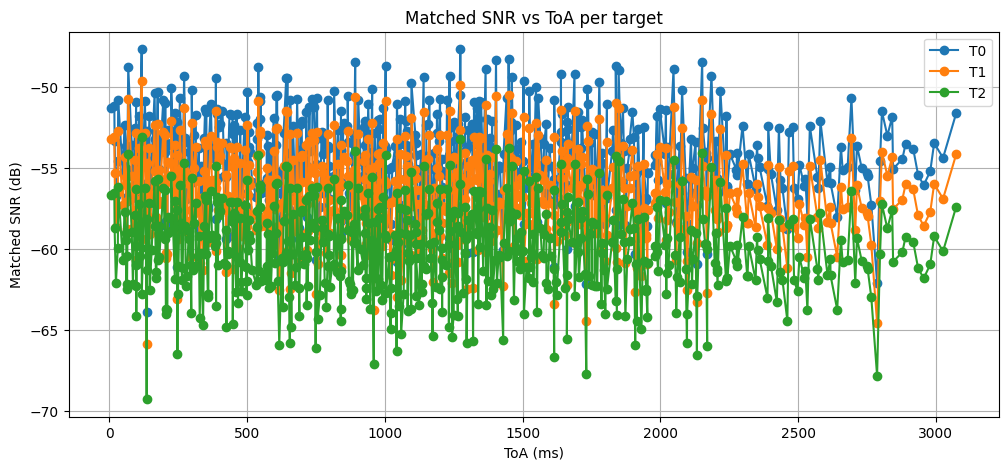

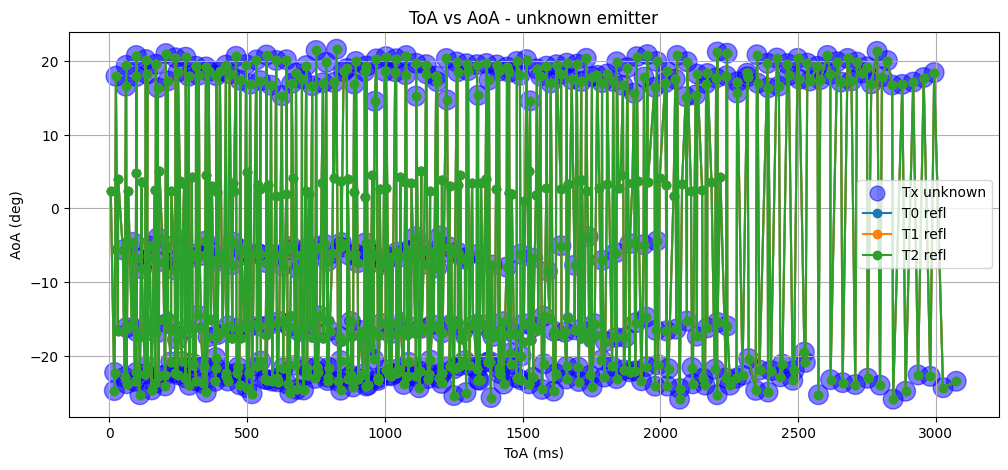

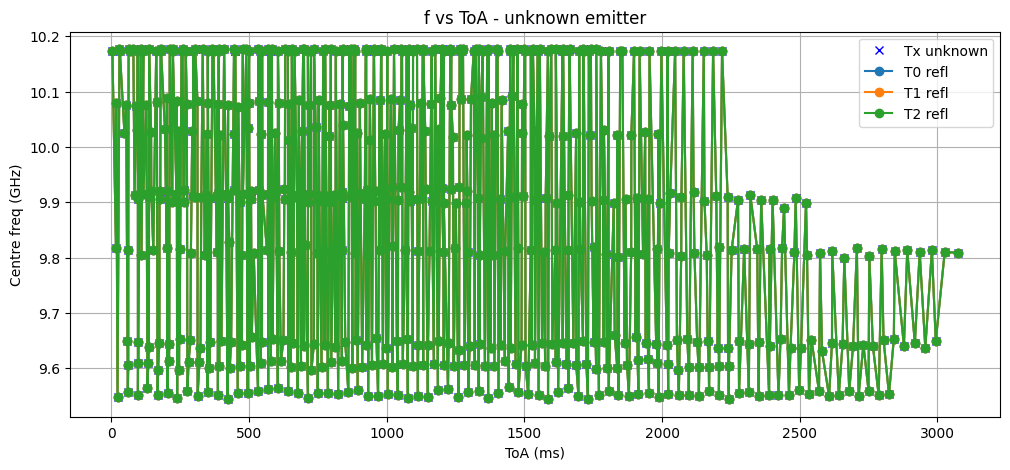

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

np.random.seed(42)
c = 299792458.0
k_B = 1.380649e-23

@dataclass
class PulseDescriptor:
    emitter_id: str
    receiver_id: str
    ToA: float
    AoA: float
    PW: float
    f_c: float
    Amplitude: float
    Phase: float
    Modulation: str
    Source: str = 'direct'
    Range_m: float = np.nan
    Doppler_Hz: float = np.nan
    SNR_dB: float = np.nan
    matched_SNR_dB: float = np.nan
    target_id: str = None

class RadarPDWGenerator:
    def __init__(self, receiver_id='R1', receiver_pos=(0.0,0.0), noise_temp=290.0,
                 noise_figure_dB=4.0, rx_beamwidth_deg=30.0, rx_max_gain_dBi=35.0):
        self.receiver_id = receiver_id
        self.receiver_pos = np.array(receiver_pos)
        self.noise_temp = noise_temp
        self.noise_figure_dB = noise_figure_dB
        self.rx_beamwidth_deg = rx_beamwidth_deg
        self.rx_max_gain_dBi = rx_max_gain_dBi

    def _jittered_times(self,start,n,pri,jitter_frac=0.05):
        base = start + np.arange(n) * pri
        jitter = (np.random.uniform(-1,1,n) * pri * jitter_frac)
        return base + jitter

    def generate_pulse_train(self, emitter_id:str, mode='pulsed',
                             n_pulses=50, start_time=0.0, pri=0.05,
                             pw_mean=1e-4, pw_jitter_frac=0.2,
                             fc_mean=10e9, fc_jitter=1e6,
                             aoa_mean=0.0, aoa_jitter=1.0,
                             amp_mean=1.0, amp_jitter_frac=0.2,
                             phase_jitter=np.pi):
        if mode=='CW':
            times = self._jittered_times(start_time,n_pulses,pri,jitter_frac=0.5)
            pws = np.full(n_pulses, pw_mean*0.1)
        else:
            times = self._jittered_times(start_time,n_pulses,pri)
            pws = pw_mean*(1 + pw_jitter_frac*np.random.randn(n_pulses))
            pws = np.clip(pws, pw_mean*0.05, pw_mean*5)
        aoas = aoa_mean + aoa_jitter*np.random.randn(n_pulses)
        amps = amp_mean * np.abs(1 + amp_jitter_frac*np.random.randn(n_pulses))
        phases = np.random.uniform(-phase_jitter, phase_jitter, size=n_pulses)
        if mode=='pulsed':
            fcs = fc_mean + np.random.randn(n_pulses)*fc_jitter
        elif mode=='freq_hop':
            fcs = fc_mean + np.linspace(-5*fc_jitter,5*fc_jitter,n_pulses)
        elif mode=='chirp':
            fcs = fc_mean + np.random.randn(n_pulses)*fc_jitter
        elif mode=='phase_code':
            fcs = fc_mean + np.random.randn(n_pulses)*fc_jitter
            phases = np.random.choice([0.0,np.pi],size=n_pulses)
        else:
            fcs = np.full(n_pulses, fc_mean)
        records = []
        for i in range(n_pulses):
            rec = PulseDescriptor(emitter_id,self.receiver_id,times[i],aoas[i],pws[i],fcs[i],
                                  amps[i],phases[i],mode)
            d = rec.__dict__.copy()
            d['tx_idx'] = i
            records.append(d)
        return pd.DataFrame.from_records(records)

    def combine_emitters(self, df_list):
        return pd.concat(df_list,ignore_index=True).sort_values('ToA').reset_index(drop=True)

# ------------------------
# Generate multiple emitters
# ------------------------
N_emitters = 10
emitter_ids = [f"E{i}" for i in range(N_emitters)]
mod_types = ['pulsed','chirp','freq_hop','phase_code','CW']
gen = RadarPDWGenerator()
tx_dfs = []

for eid in emitter_ids:
    mode = np.random.choice(mod_types)
    n_pulses = np.random.randint(40,80)
    start_time = np.random.rand()*0.1
    pri = 0.03 + 0.02*np.random.rand()
    pw_mean = 100e-6 + np.random.rand()*200e-6
    fc_mean = 9.5e9 + np.random.rand()*0.7e9
    aoa_mean = -30 + np.random.rand()*60
    amp_mean = 1.0 + np.random.rand()*2.0
    df = gen.generate_pulse_train(eid, mode,n_pulses,start_time,pri,pw_mean,pw_jitter_frac=0.2,
                                  fc_mean=fc_mean,fc_jitter=5e6,aoa_mean=aoa_mean,amp_mean=amp_mean)
    tx_dfs.append(df)

tx_all = gen.combine_emitters(tx_dfs)
tx_all['ToA_ms'] = tx_all['ToA']*1e3
tx_all['PW_us'] = tx_all['PW']*1e6
tx_all['f_GHz'] = tx_all['f_c']/1e9

# ------------------------
# Simulate multiple moving targets
# ------------------------
N_targets = 3
target_ids = [f"T{i}" for i in range(N_targets)]
target_states = []
t_step = 0.01  # seconds
t_max = tx_all['ToA'].max() + 0.05
t_array = np.arange(0,t_max,t_step)

for tid in target_ids:
    pos0 = np.random.uniform(500,3000)
    vel = np.random.uniform(-50,50)
    acc = np.random.uniform(-5,5)
    target_states.append({'target_id':tid,'pos0':pos0,'vel':vel,'acc':acc})

refl_records = []
for t in range(len(tx_all)):
    tx = tx_all.iloc[t]
    for tgt in target_states:
        # Compute range at this pulse ToA
        dt = tx['ToA']
        R = tgt['pos0'] + tgt['vel']*dt + 0.5*tgt['acc']*dt**2
        # Doppler
        v = tgt['vel'] + tgt['acc']*dt
        f_dop = 2*v/ c * tx['f_c']
        # Matched SNR approx: simple inverse square law
        snr_dB = 10*np.log10(tx['Amplitude']**2 / (R**2 + 1e-6))
        matched_snr_dB = snr_dB + 3.0
        rec = tx.copy()
        rec['Source'] = 'reflection'
        rec['Range_m'] = R
        rec['Doppler_Hz'] = f_dop
        rec['SNR_dB'] = snr_dB
        rec['matched_SNR_dB'] = matched_snr_dB
        rec['target_id'] = tgt['target_id']
        refl_records.append(rec)

refl_all = pd.DataFrame.from_records(refl_records)
refl_all['ToA_ms'] = refl_all['ToA']*1e3
refl_all['PW_us'] = refl_all['PW']*1e6
refl_all['f_GHz'] = refl_all['f_c']/1e9

# ------------------------
# Plot 1: emitters coloured, targets reflected
# ------------------------
plt.figure(figsize=(12,5))
for eid,grp in tx_all.groupby('emitter_id'):
    plt.scatter(grp['ToA_ms'],grp['AoA'],s=np.clip(grp['PW_us']*2,5,200),label=eid,alpha=0.5)
for tid,grp in refl_all.groupby('target_id'):
    plt.plot(grp['ToA_ms'],grp['AoA'],marker='o',linestyle='-',label=f'{tid} refl')
plt.xlabel('ToA (ms)'); plt.ylabel('AoA (deg)'); plt.title('ToA vs AoA - emitters & targets'); plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for eid,grp in tx_all.groupby('emitter_id'):
    plt.plot(grp['ToA_ms'],grp['f_GHz'],marker='x',linestyle='None',label=eid)
for tid,grp in refl_all.groupby('target_id'):
    plt.plot(grp['ToA_ms'],grp['f_GHz'],marker='o',linestyle='-',label=f'{tid} refl')
plt.xlabel('ToA (ms)'); plt.ylabel('Centre freq (GHz)'); plt.title('f vs ToA - emitters & targets'); plt.grid(True); plt.legend()
plt.show()

# Doppler plot per target
plt.figure(figsize=(12,5))
for tid,grp in refl_all.groupby('target_id'):
    plt.plot(grp['ToA_ms'],grp['Doppler_Hz'],marker='o',linestyle='-',label=tid)
plt.xlabel('ToA (ms)'); plt.ylabel('Doppler (Hz)'); plt.title('Reflected Doppler vs ToA per target'); plt.grid(True); plt.legend()
plt.show()

# Matched SNR
plt.figure(figsize=(12,5))
for tid,grp in refl_all.groupby('target_id'):
    plt.plot(grp['ToA_ms'],grp['matched_SNR_dB'],marker='o',linestyle='-',label=tid)
plt.xlabel('ToA (ms)'); plt.ylabel('Matched SNR (dB)'); plt.title('Matched SNR vs ToA per target'); plt.grid(True); plt.legend()
plt.show()

# ------------------------
# Plot 2: unknown emitter (all same colour)
# ------------------------
plt.figure(figsize=(12,5))
plt.scatter(tx_all['ToA_ms'],tx_all['AoA'],s=np.clip(tx_all['PW_us']*2,5,200),c='blue',alpha=0.5,label='Tx unknown')
for tid,grp in refl_all.groupby('target_id'):
    plt.plot(grp['ToA_ms'],grp['AoA'],marker='o',linestyle='-',label=f'{tid} refl')
plt.xlabel('ToA (ms)'); plt.ylabel('AoA (deg)'); plt.title('ToA vs AoA - unknown emitter'); plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(tx_all['ToA_ms'],tx_all['f_GHz'],marker='x',linestyle='None',color='blue',label='Tx unknown')
for tid,grp in refl_all.groupby('target_id'):
    plt.plot(grp['ToA_ms'],grp['f_GHz'],marker='o',linestyle='-',label=f'{tid} refl')
plt.xlabel('ToA (ms)'); plt.ylabel('Centre freq (GHz)'); plt.title('f vs ToA - unknown emitter'); plt.grid(True); plt.legend()
plt.show()


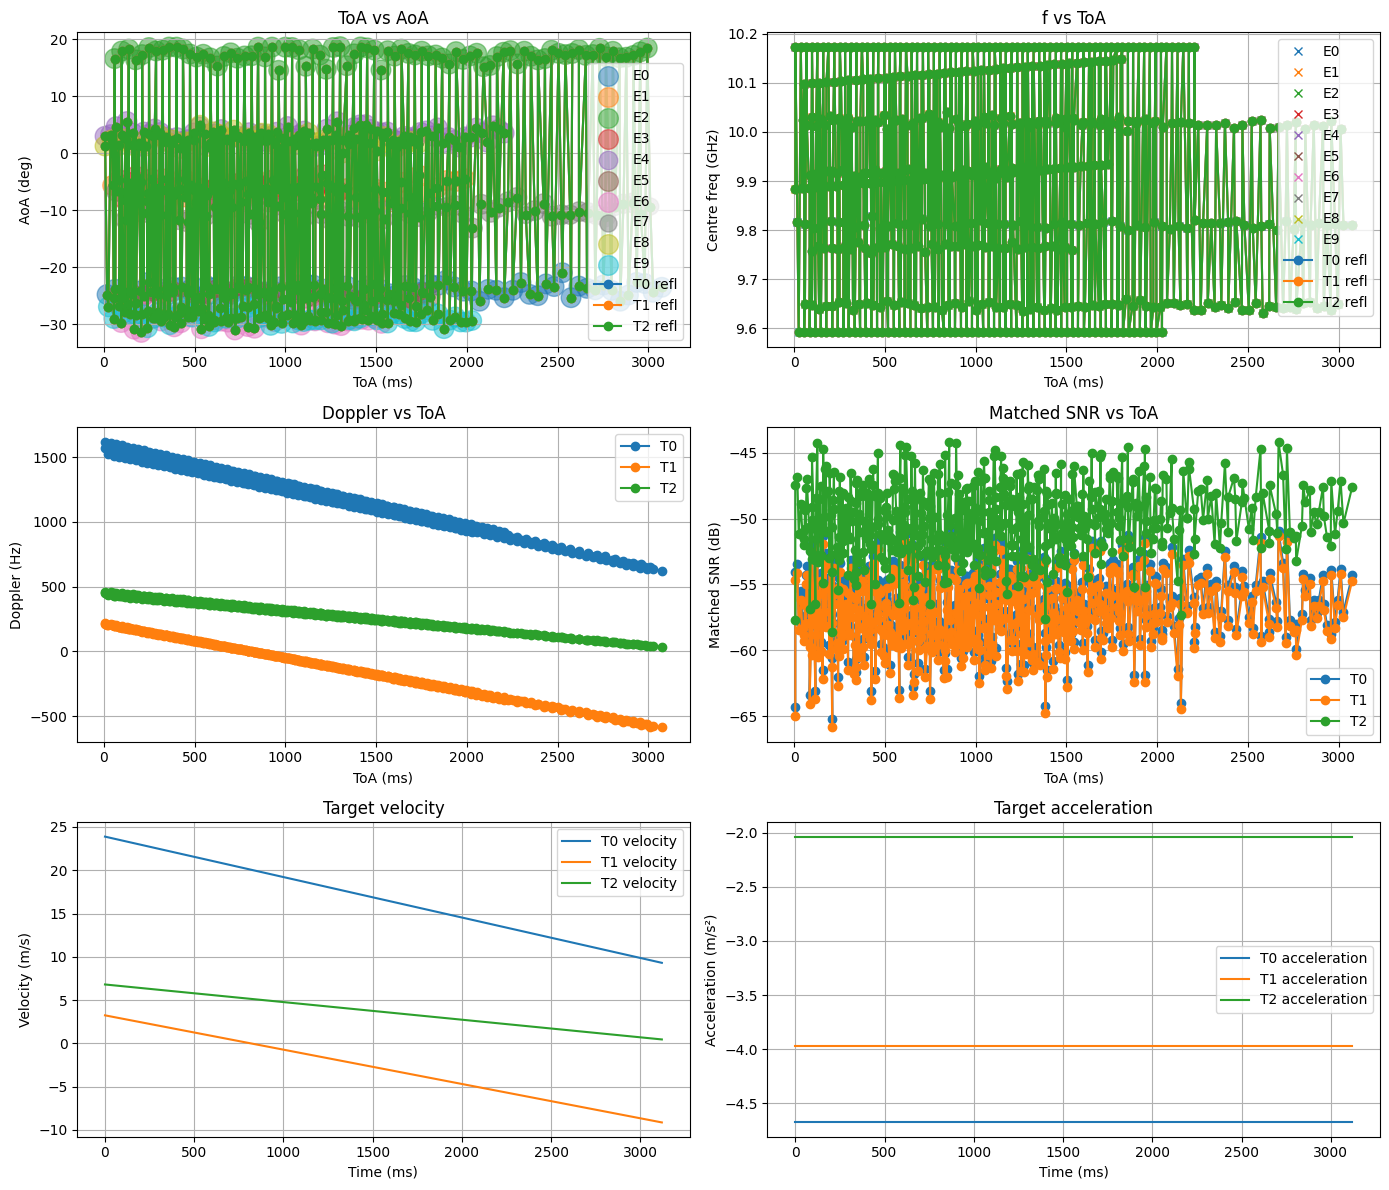

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ------------------------
# Constants
# ------------------------
c = 299792458.0  # speed of light
np.random.seed(42)

# ------------------------
# Data classes
# ------------------------
@dataclass
class PulseDescriptor:
    emitter_id: str
    receiver_id: str
    ToA: float
    AoA: float
    PW: float
    f_c: float
    Amplitude: float
    Phase: float
    Modulation: str
    Source: str = 'direct'
    Range_m: float = np.nan
    Doppler_Hz: float = np.nan
    SNR_dB: float = np.nan
    matched_SNR_dB: float = np.nan
    target_id: str = None

# ------------------------
# Radar PDW Generator
# ------------------------
class RadarPDWGenerator:
    def __init__(self, receiver_id='R1', receiver_pos=(0.0,0.0)):
        self.receiver_id = receiver_id
        self.receiver_pos = np.array(receiver_pos)

    def _jittered_times(self,start,n,pri,jitter_frac=0.05):
        return start + np.arange(n)*pri + np.random.uniform(-1,1,n)*pri*jitter_frac

    def generate_pulse_train(self, emitter_id:str, mode='pulsed',
                             n_pulses=50, start_time=0.0, pri=0.05,
                             pw_mean=1e-4, pw_jitter_frac=0.2,
                             fc_mean=10e9, fc_jitter=1e6,
                             aoa_mean=0.0, aoa_jitter=1.0,
                             amp_mean=1.0, amp_jitter_frac=0.2):
        times = self._jittered_times(start_time,n_pulses,pri)
        pws = np.clip(pw_mean*(1 + pw_jitter_frac*np.random.randn(n_pulses)), pw_mean*0.05, pw_mean*5)
        aoas = aoa_mean + aoa_jitter*np.random.randn(n_pulses)
        amps = amp_mean * np.abs(1 + amp_jitter_frac*np.random.randn(n_pulses))
        phases = np.random.uniform(-np.pi, np.pi, size=n_pulses)
        if mode=='pulsed':
            fcs = fc_mean + np.random.randn(n_pulses)*fc_jitter
        elif mode=='freq_hop':
            fcs = fc_mean + np.linspace(-5*fc_jitter,5*fc_jitter,n_pulses)
        elif mode=='chirp':
            fcs = fc_mean + np.random.randn(n_pulses)*fc_jitter
        elif mode=='phase_code':
            fcs = fc_mean + np.random.randn(n_pulses)*fc_jitter
            phases = np.random.choice([0.0,np.pi],size=n_pulses)
        else:  # CW
            fcs = np.full(n_pulses, fc_mean)
        records = [PulseDescriptor(emitter_id,self.receiver_id,times[i],aoas[i],pws[i],
                                   fcs[i],amps[i],phases[i],mode).__dict__ for i in range(n_pulses)]
        return pd.DataFrame.from_records(records)

    @staticmethod
    def combine_emitters(df_list):
        return pd.concat(df_list,ignore_index=True).sort_values('ToA').reset_index(drop=True)

# ------------------------
# Generate emitters
# ------------------------
N_emitters = 10
emitter_ids = [f"E{i}" for i in range(N_emitters)]
mod_types = ['pulsed','chirp','freq_hop','phase_code','CW']
gen = RadarPDWGenerator()
tx_dfs = []

for eid in emitter_ids:
    mode = np.random.choice(mod_types)
    n_pulses = np.random.randint(40,80)
    start_time = np.random.rand()*0.1
    pri = 0.03 + 0.02*np.random.rand()
    pw_mean = 100e-6 + np.random.rand()*200e-6
    fc_mean = 9.5e9 + np.random.rand()*0.7e9
    aoa_mean = -30 + np.random.rand()*60
    amp_mean = 1.0 + np.random.rand()*2.0
    df = gen.generate_pulse_train(eid, mode,n_pulses,start_time,pri,pw_mean,pw_jitter_frac=0.2,
                                  fc_mean=fc_mean,fc_jitter=5e6,aoa_mean=aoa_mean,amp_mean=amp_mean)
    tx_dfs.append(df)

tx_all = gen.combine_emitters(tx_dfs)
tx_all['ToA_ms'] = tx_all['ToA']*1e3
tx_all['PW_us'] = tx_all['PW']*1e6
tx_all['f_GHz'] = tx_all['f_c']/1e9

# ------------------------
# Generate moving targets
# ------------------------
N_targets = 3
target_ids = [f"T{i}" for i in range(N_targets)]
t_step = 0.01
t_max = tx_all['ToA'].max() + 0.05
t_array = np.arange(0,t_max,t_step)

target_states = []
for tid in target_ids:
    pos0 = np.random.uniform(500,3000)
    vel = np.random.uniform(-50,50)
    acc = np.random.uniform(-5,5)
    target_states.append({'target_id':tid,'pos0':pos0,'vel':vel,'acc':acc})

# ------------------------
# Compute reflections
# ------------------------
refl_records = []
for t in range(len(tx_all)):
    tx = tx_all.iloc[t]
    for tgt in target_states:
        dt = tx['ToA']
        R = tgt['pos0'] + tgt['vel']*dt + 0.5*tgt['acc']*dt**2
        v = tgt['vel'] + tgt['acc']*dt
        f_dop = 2*v/c*tx['f_c']
        snr_dB = 10*np.log10(tx['Amplitude']**2/(R**2+1e-6))
        matched_snr_dB = snr_dB + 3.0
        rec = tx.copy()
        rec.update({'Source':'reflection','Range_m':R,'Doppler_Hz':f_dop,
                    'SNR_dB':snr_dB,'matched_SNR_dB':matched_snr_dB,'target_id':tgt['target_id']})
        refl_records.append(rec)

refl_all = pd.DataFrame.from_records(refl_records)
refl_all['ToA_ms'] = refl_all['ToA']*1e3
refl_all['PW_us'] = refl_all['PW']*1e6
refl_all['f_GHz'] = refl_all['f_c']/1e9

# ------------------------
# Dashboard plot
# ------------------------
fig, axs = plt.subplots(3,2,figsize=(14,12))

# ToA vs AoA
for eid,grp in tx_all.groupby('emitter_id'):
    axs[0,0].scatter(grp['ToA_ms'],grp['AoA'],s=np.clip(grp['PW_us']*2,5,200),label=eid,alpha=0.5)
for tid,grp in refl_all.groupby('target_id'):
    axs[0,0].plot(grp['ToA_ms'],grp['AoA'],marker='o',linestyle='-',label=f'{tid} refl')
axs[0,0].set_xlabel('ToA (ms)'); axs[0,0].set_ylabel('AoA (deg)'); axs[0,0].set_title('ToA vs AoA'); axs[0,0].grid(True); axs[0,0].legend()

# ToA vs Centre Frequency
for eid,grp in tx_all.groupby('emitter_id'):
    axs[0,1].plot(grp['ToA_ms'],grp['f_GHz'],marker='x',linestyle='None',label=eid)
for tid,grp in refl_all.groupby('target_id'):
    axs[0,1].plot(grp['ToA_ms'],grp['f_GHz'],marker='o',linestyle='-',label=f'{tid} refl')
axs[0,1].set_xlabel('ToA (ms)'); axs[0,1].set_ylabel('Centre freq (GHz)'); axs[0,1].set_title('f vs ToA'); axs[0,1].grid(True); axs[0,1].legend()

# Doppler vs ToA
for tid,grp in refl_all.groupby('target_id'):
    axs[1,0].plot(grp['ToA_ms'],grp['Doppler_Hz'],marker='o',linestyle='-',label=tid)
axs[1,0].set_xlabel('ToA (ms)'); axs[1,0].set_ylabel('Doppler (Hz)'); axs[1,0].set_title('Doppler vs ToA'); axs[1,0].grid(True); axs[1,0].legend()

# Matched SNR vs ToA
for tid,grp in refl_all.groupby('target_id'):
    axs[1,1].plot(grp['ToA_ms'],grp['matched_SNR_dB'],marker='o',linestyle='-',label=tid)
axs[1,1].set_xlabel('ToA (ms)'); axs[1,1].set_ylabel('Matched SNR (dB)'); axs[1,1].set_title('Matched SNR vs ToA'); axs[1,1].grid(True); axs[1,1].legend()

# Target velocity vs time
for tgt in target_states:
    vel_array = tgt['vel'] + tgt['acc']*t_array
    axs[2,0].plot(t_array*1e3, vel_array, label=f"{tgt['target_id']} velocity")
axs[2,0].set_xlabel('Time (ms)'); axs[2,0].set_ylabel('Velocity (m/s)'); axs[2,0].set_title('Target velocity'); axs[2,0].grid(True); axs[2,0].legend()

# Target acceleration vs time
for tgt in target_states:
    acc_array = np.full_like(t_array, tgt['acc'])
    axs[2,1].plot(t_array*1e3, acc_array, label=f"{tgt['target_id']} acceleration")
axs[2,1].set_xlabel('Time (ms)'); axs[2,1].set_ylabel('Acceleration (m/s²)'); axs[2,1].set_title('Target acceleration'); axs[2,1].grid(True); axs[2,1].legend()

plt.tight_layout()
plt.show()


In [14]:
pip install dash

Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
import dash
from dash import dcc, html
import plotly.express as px
import plotly.graph_objects as go

# ------------------------
# Simulation setup
# ------------------------
c = 299792458.0
np.random.seed(42)

@dataclass
class PulseDescriptor:
    emitter_id: str
    receiver_id: str
    ToA: float
    AoA: float
    PW: float
    f_c: float
    Amplitude: float
    Phase: float
    Modulation: str
    Source: str = 'direct'
    Range_m: float = np.nan
    Doppler_Hz: float = np.nan
    SNR_dB: float = np.nan
    matched_SNR_dB: float = np.nan
    target_id: str = None

class RadarPDWGenerator:
    def __init__(self, receiver_id='R1'):
        self.receiver_id = receiver_id

    def _jittered_times(self,start,n,pri,jitter_frac=0.05):
        return start + np.arange(n)*pri + np.random.uniform(-1,1,n)*pri*jitter_frac

    def generate_pulse_train(self, emitter_id, mode='pulsed', n_pulses=50,
                             start_time=0.0, pri=0.05, pw_mean=1e-4,
                             pw_jitter_frac=0.2, fc_mean=10e9, fc_jitter=1e6,
                             aoa_mean=0.0, aoa_jitter=1.0, amp_mean=1.0):
        times = self._jittered_times(start_time,n_pulses,pri)
        pws = np.clip(pw_mean*(1 + pw_jitter_frac*np.random.randn(n_pulses)), pw_mean*0.05, pw_mean*5)
        aoas = aoa_mean + aoa_jitter*np.random.randn(n_pulses)
        amps = amp_mean * np.abs(1 + amp_jitter_frac*np.random.randn(n_pulses))
        phases = np.random.uniform(-np.pi, np.pi, size=n_pulses)
        fcs = fc_mean + np.random.randn(n_pulses)*fc_jitter
        records = [PulseDescriptor(emitter_id,self.receiver_id,times[i],aoas[i],pws[i],
                                   fcs[i],amps[i],phases[i],mode).__dict__ for i in range(n_pulses)]
        return pd.DataFrame.from_records(records)

    @staticmethod
    def combine_emitters(df_list):
        return pd.concat(df_list,ignore_index=True).sort_values('ToA').reset_index(drop=True)

# ------------------------
# Generate multiple emitters
# ------------------------
N_emitters = 10
emitter_ids = [f"E{i}" for i in range(N_emitters)]
mod_types = ['pulsed','chirp','freq_hop','phase_code','CW']
gen = RadarPDWGenerator()
tx_dfs = []

for eid in emitter_ids:
    mode = np.random.choice(mod_types)
    n_pulses = np.random.randint(40,80)
    start_time = np.random.rand()*0.1
    pri = 0.03 + 0.02*np.random.rand()
    pw_mean = 100e-6 + np.random.rand()*200e-6
    fc_mean = 9.5e9 + np.random.rand()*0.7e9
    aoa_mean = -30 + np.random.rand()*60
    amp_mean = 1.0 + np.random.rand()*2.0
    df = gen.generate_pulse_train(eid, mode,n_pulses,start_time,pri,pw_mean,
                                  pw_jitter_frac=0.2,fc_mean=fc_mean,fc_jitter=5e6,
                                  aoa_mean=aoa_mean,amp_mean=amp_mean)
    tx_dfs.append(df)

tx_all = gen.combine_emitters(tx_dfs)
tx_all['ToA_ms'] = tx_all['ToA']*1e3
tx_all['PW_us'] = tx_all['PW']*1e6
tx_all['f_GHz'] = tx_all['f_c']/1e9

# ------------------------
# Targets
# ------------------------
N_targets = 3
target_ids = [f"T{i}" for i in range(N_targets)]
t_step = 0.01
t_max = tx_all['ToA'].max() + 0.05
t_array = np.arange(0,t_max,t_step)

target_states = []
for tid in target_ids:
    pos0 = np.random.uniform(500,3000)
    vel = np.random.uniform(-50,50)
    acc = np.random.uniform(-5,5)
    target_states.append({'target_id':tid,'pos0':pos0,'vel':vel,'acc':acc})

# Reflections
refl_records = []
for t in range(len(tx_all)):
    tx = tx_all.iloc[t]
    for tgt in target_states:
        dt = tx['ToA']
        R = tgt['pos0'] + tgt['vel']*dt + 0.5*tgt['acc']*dt**2
        v = tgt['vel'] + tgt['acc']*dt
        f_dop = 2*v/c*tx['f_c']
        snr_dB = 10*np.log10(tx['Amplitude']**2/(R**2+1e-6))
        matched_snr_dB = snr_dB + 3.0
        rec = tx.copy()
        rec.update({'Source':'reflection','Range_m':R,'Doppler_Hz':f_dop,
                    'SNR_dB':snr_dB,'matched_SNR_dB':matched_snr_dB,'target_id':tgt['target_id']})
        refl_records.append(rec)

refl_all = pd.DataFrame.from_records(refl_records)
refl_all['ToA_ms'] = refl_all['ToA']*1e3
refl_all['f_GHz'] = refl_all['f_c']/1e9

# ------------------------
# Build Dash app
# ------------------------
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Radar PDW Interactive Dashboard"),
    
    html.Label("Select Emitter (empty = all unknown):"),
    dcc.Dropdown(
        id='emitter-filter',
        options=[{'label': eid, 'value': eid} for eid in emitter_ids],
        value=[],
        multi=True
    ),
    
    dcc.Graph(id='toa-aoa'),
    dcc.Graph(id='toa-f'),
    dcc.Graph(id='doppler'),
    dcc.Graph(id='snr')
])

@app.callback(
    [dash.dependencies.Output('toa-aoa','figure'),
     dash.dependencies.Output('toa-f','figure'),
     dash.dependencies.Output('doppler','figure'),
     dash.dependencies.Output('snr','figure')],
    [dash.dependencies.Input('emitter-filter','value')]
)
def update_graphs(selected_emitters):
    if selected_emitters:
        tx_df = tx_all[tx_all['emitter_id'].isin(selected_emitters)]
    else:
        tx_df = tx_all.copy()
        tx_df['emitter_id'] = 'unknown'
    
    # ToA vs AoA
    fig1 = px.scatter(tx_df, x='ToA_ms', y='AoA', color='emitter_id',
                      size='PW_us', hover_data=['f_GHz','Amplitude'])
    for tid,grp in refl_all.groupby('target_id'):
        fig1.add_trace(go.Scatter(x=grp['ToA_ms'],y=grp['AoA'],mode='lines+markers',
                                  name=f'{tid} refl'))
    
    # ToA vs f
    fig2 = px.scatter(tx_df, x='ToA_ms', y='f_GHz', color='emitter_id', hover_data=['AoA','PW_us'])
    for tid,grp in refl_all.groupby('target_id'):
        fig2.add_trace(go.Scatter(x=grp['ToA_ms'],y=grp['f_GHz'],mode='lines+markers',
                                  name=f'{tid} refl'))
    
    # Doppler
    fig3 = go.Figure()
    for tid,grp in refl_all.groupby('target_id'):
        fig3.add_trace(go.Scatter(x=grp['ToA_ms'],y=grp['Doppler_Hz'],mode='lines+markers',name=tid))
    
    # Matched SNR
    fig4 = go.Figure()
    for tid,grp in refl_all.groupby('target_id'):
        fig4.add_trace(go.Scatter(x=grp['ToA_ms'],y=grp['matched_SNR_dB'],mode='lines+markers',name=tid))
    
    return fig1, fig2, fig3, fig4

if __name__=='__main__':
    app.run_server(debug=True)


NameError: name 'amp_jitter_frac' is not defined